In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl


In [2]:
# time.sleep(40)

In [3]:
total_count = 48


In [4]:


def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
        if not line.startswith('--') and 'current ops/sec; [UPDATE AverageLatency' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())
            
            print(line,latencies[-1],thputs[-1],times[-1])

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  






def getTimeThps(file, flag):
    
    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)
        
    return np.array(times).astype(float), np.array(thputs).astype(float) 

In [5]:
# os.system("aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")



# os.system("aws --region ap-south-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

In [6]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines, len(lines)

(['43.204.234.202',
  '52.66.236.170',
  '3.109.121.28',
  '3.108.63.142',
  '15.207.221.92',
  '13.232.156.1',
  '13.233.159.147',
  '65.1.112.85',
  '43.204.235.114',
  '15.207.89.149',
  '13.233.60.45',
  '3.109.122.237',
  '13.232.109.153',
  '3.109.58.37',
  '35.154.223.170',
  '3.109.210.44',
  '35.154.163.148',
  '15.207.249.129',
  '43.204.141.20',
  '13.235.70.220',
  '52.66.248.129',
  '35.154.45.209',
  '13.233.96.203',
  '3.108.249.148',
  '13.127.235.249',
  '65.2.70.187',
  '43.204.212.87',
  '65.1.95.212',
  '43.204.101.113',
  '3.111.39.39',
  '13.233.122.252',
  '65.2.70.117',
  '13.233.115.171',
  '13.233.30.95',
  '65.0.71.74',
  '65.2.142.166',
  '3.7.65.152',
  '13.234.29.126',
  '13.233.69.166',
  '13.232.118.112',
  '65.1.106.227',
  '52.66.113.250',
  '13.127.152.12',
  '15.206.194.146',
  '15.206.179.46',
  '43.204.110.211',
  '65.0.109.191',
  '43.204.141.232',
  '52.66.253.81',
  '15.206.209.232',
  '43.204.228.172'],
 51)

In [7]:
for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "FinalKeys.pem" ubuntu@ec2-43-204-234-202.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-52-66-236-170.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-109-121-28.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-108-63-142.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-15-207-221-92.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-232-156-1.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-233-159-147.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-1-112-85.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-43-204-235-114.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-15-207-89-149.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-233-60-45.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-109-122-237.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-232-10

In [8]:
## Set number of clusters

nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)




nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

nclients = nclusters

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]



# clientIps = lines[-(nclusters):]
clientIps = lines[-nclients:]



clientIps, no_cluster_yet_nodes

3


(['52.66.253.81', '15.206.209.232', '43.204.228.172'], [])

In [9]:
## Functions

def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:commands.sh'
        
        print(command)
        os.system(command)
        
def initialize(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
        os.system(command)
        
        
def git_clone(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'
        
        
        os.system(command)
        
def git_pull(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/BftSmart_Final; cd BftSmart_Final; sudo git pull"'
        
        
        os.system(command)
        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo ./gradlew installDist"'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
    rm_command = 'sudo rm config/currentView; '
    for iter_ in range(nclusters):
        rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'
        
        
        os.system(command)
        
        
def clean_all(i):
    ip = lines[i]
    
    rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
        os.system(command)
        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)        
#         print(command)

def check_node(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
        os.system(command)
#         print(command)


def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
        print(command)

In [10]:
# for i in range(len(lines)):
#     run_basic_client_check(i)
    

# def setup(i):

#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
#         os.system(command)
        
# def initialize(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
#         os.system(command)
        
        
# def git_clone(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t " sudo git clone https://tmane002@bitbucket.org/tmane002/BftSmart_Final.git"'
        
        
#         os.system(command)
        
# def git_pull(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/bftsmartt; cd bftsmartt; sudo git pull"'
        
        
#         os.system(command)
        
# def compile_job(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo ./gradlew installDist"'
        
        
#         os.system(command)

        
        
# def clean_job(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; cd bftsmartt; '+rm_command+'"'
        
        
#         os.system(command)
        
        
# def clean_all(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm -r bftsmartt; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
#         os.system(command)
        
# def run_server_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)
        
        
        
#     if ip!='None' and( ip in no_cluster_yet_nodes):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)        
# #         print(command)

# def check_node(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
#         os.system(command)
# #         print(command)


# def run_basic_client(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
# #     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
#         current = (ip.split('.'))
        
# #         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
#         os.system(command)


# def kill_java(i):
#     ip = lines[i]
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)
        
        
        
# def kill_clients(i):
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)

# def run_server_node_check(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         print(command)
        
        

# # for i in range(len(lines)):
# #     run_server_node_check(i)

# def run_basic_client_check(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
#         print(command)

# # for i in range(len(lines)):
# #     run_basic_client_check(i)
    

In [11]:
## First Time Setup

lines, len(lines)

(['43.204.234.202',
  '52.66.236.170',
  '3.109.121.28',
  '3.108.63.142',
  '15.207.221.92',
  '13.232.156.1',
  '13.233.159.147',
  '65.1.112.85',
  '43.204.235.114',
  '15.207.89.149',
  '13.233.60.45',
  '3.109.122.237',
  '13.232.109.153',
  '3.109.58.37',
  '35.154.223.170',
  '3.109.210.44',
  '35.154.163.148',
  '15.207.249.129',
  '43.204.141.20',
  '13.235.70.220',
  '52.66.248.129',
  '35.154.45.209',
  '13.233.96.203',
  '3.108.249.148',
  '13.127.235.249',
  '65.2.70.187',
  '43.204.212.87',
  '65.1.95.212',
  '43.204.101.113',
  '3.111.39.39',
  '13.233.122.252',
  '65.2.70.117',
  '13.233.115.171',
  '13.233.30.95',
  '65.0.71.74',
  '65.2.142.166',
  '3.7.65.152',
  '13.234.29.126',
  '13.233.69.166',
  '13.232.118.112',
  '65.1.106.227',
  '52.66.113.250',
  '13.127.152.12',
  '15.206.194.146',
  '15.206.179.46',
  '43.204.110.211',
  '65.0.109.191',
  '43.204.141.232',
  '52.66.253.81',
  '15.206.209.232',
  '43.204.228.172'],
 51)

In [12]:
# for i in range(10):
#     setup(i)


results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Warning: Permanently added 'ec2-43-204-234-202.ap-south-1.compute.amazonaws.com' (ED25519) to the list of known hosts.
[sudo] password for tejas: Warning: Permanently added 'ec2-3-109-121-28.ap-south-1.compute.amazonaws.com' (ED25519) to the list of known hosts.
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Warning: Permanently added 'ec2-65-1-112-85.ap-south-1.compute.amazonaws.com' (ED25519) to the list of known hosts.
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [13]:
results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-ter

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-

Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [20.7 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [9704 B]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 c-n-f Metadata [476 B]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [40.9 kB]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main Translation-en [10.2 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [208 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f

Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [208 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.4 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [663 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [106 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [528 B]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [142 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:18 http

Get:29 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:30 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [752 kB]
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 c-n-f Metadata [388 B]
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/restricted amd64 c-n-f Metadata [116 B]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main Translation-en [10.2 kB]
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 c-n-f Metadata [388 B]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [89.0 kB]
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/restricted amd64 c-n-f Metadata [116 B]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [135 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [135 kB]
Get:36 http:

Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [949 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [204 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [20.7 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [9704 B]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 c-n-f Metadata [

Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [580 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Meta

The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto

Reading state information...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 linux-libc-dev amd64 5.15.0-78.85 [1307 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64

Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-1

Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  

Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.1.0-2ubuntu1~22.04 [976 kB]

Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
0 upgraded, 52 newly installed, 0 to remove and 85 not upgraded.
Need to get 63.6 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-dev-bin amd64 2.35-0ubuntu3.1 [20.4 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2516 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.3.0-1ubuntu1~22.04.1 [20.9 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-

Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2516 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.1.0-2ubuntu1~22.04 [976 kB]
0 upgraded, 52 newly installed, 0 to remove and 85 not upgraded.
Need to get 63.6 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-dev-bin amd64 2.35-0ubuntu3.1 [20.4 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc

Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.2 [922 kB]
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:34 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
Get:35 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1ubuntu1 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:50 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-devtools amd64 2.35-0ubuntu3.1 [28.9 kB]
Get:51 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfile-fcntllock-perl amd64 0.22-3build7 [33.9 kB]
Selecting previously unselected package libc-dev-bin.
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:52 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 manpages-dev all 5.10-1ubuntu1 [2309 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.3.0-1ubuntu1~22.04.1 [9968 kB]
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Get:39 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.0

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Selecting previously unselected package libc-dev-bin.
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:34 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
Get:35 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1ubuntu1 [60.4 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.1.0-2ubuntu1~22.04 [47.4 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.1.0-2ubuntu1~22.04 [126 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libitm1 amd64 12.1.0-2ubuntu1~22.04 [30.2 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libatomic1 amd64 12.1.0-2ubuntu1~22.0

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Selecting previously unselected package linux-libc-dev:amd64.
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.1.0-2ubuntu1~22.04 [976 kB]
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.2 [922 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/mai

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]
Selecting previously unselected package libnsl-dev:amd64.
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.0-1ubuntu1~22.04.1 [11.4 MB]
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
(Reading database ... 64295 files and directories currently installed.)
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline



Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.3.0-1ubuntu1~22.04.1 [20.9 kB]
Unpacking libisl23:amd64 (0.24-2build1) ...
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2build1 [727 kB]
Selecting previously unselected package rpcsvc-proto.
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.3.0-1ubuntu1~22.04.1 [9968 kB]
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../04-

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package rpcsvc-proto.
Selecting previously unselected package linux-libc-dev:amd64.
Unpacking libisl23:amd64 (0.24-2build1) ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Selecting previously unselected package libc6-dev:amd64.
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...Unpacking linux-libc-dev:amd64 (5.15.0-78.85) ...

Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]
Selecting previou

Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Unpacking gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
Selecting previously unselected package cpp.
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2516 kB]
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libnsl-dev:amd64.
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Preparing to unpack .../15-libatomic1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Unpacking libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package rpcsvc-proto.
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package cpp.
Selecting previously unselected package libisl23:amd64.
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package libc6-dev:amd64.
Unpacking libisl23:amd64 (0.24-2build1) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Unpacking liblsan0:amd64 (12.1.0-2ubun

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 95%
Reading state information...
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package liblsan0:amd64.
Selecting previously unselected package gcc-11-base:amd64.
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libasan6:amd64.
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.0

Unpacking libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package cpp.
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Get:39 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Unpacking cpp (4:11.2.0-1ubuntu1) ...Get:40 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]

Get:41 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
Get:42 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Get:43 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libstdc++-11-dev:amd64.
Preparing to unpack .../24-libstdc++-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package g++.
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.1.0-2ubuntu1~22.04 [47.4 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.1.0-2ubuntu1~22.04 [126 kB]
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libitm1 amd64 12.1.0-2ubuntu1~22.04 [30.2 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libatomic1 amd64 12.1.0-2ubuntu1~22.04 [10.4 kB]
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Get:17 http://ap-south-1.

Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package rpcsvc-proto.
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package build-essential.
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Preparing to unpack .../18-libtsan0_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking build-essential (12.9ubuntu3) ..

Unpacking lto-disabled-list (24) ...
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package libwebp7:amd64.
Selecting previously unselected package g++-11.
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Selecting previously unselected package g++.
Unpacking g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...


Selecting previously unselected package libalgorithm-merge-perl.
Selecting previously unselected package libjpeg8:amd64.Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...

Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package bzip2.
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Selecting previously unselected package libc-devtools.
Unpacking bzip2 (1.0.8-5build1) ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Selecting previously unselected package libatomic1:amd64.
Selecting previously unselected package libalgorithm-diff-xs-perl.
Selecting previously unselected package g++.
Preparing to unpack .../15-libatomic1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../38-libalgorithm-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libc-devtools.
Selecting previously unselected package libjbig0:amd64.
Unpacking libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Setting up gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package libtiff5:amd64.
Selecting previously unselected package fonts-dejavu-core.
Setting up manpages-dev (5.10-1ubuntu1) ...
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Selecting previously unselected package libfontconfig1:amd64.
Unpacking fonts-dejavu-core (2.37-2build1) ...
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Setting up l

Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package lto-disabled-list.
Setting up libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Unpacking lto-disabled-list (24) ...
Setting up fakeroot (1.28-1ubuntu1) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Selecting previously unselected package libfontconfig1:amd64.
Selecting previously unselected package manpages-dev.
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Unpacking libfontconf

Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Setting up liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...
Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Selecting previously unselected package dpkg-dev.
Setting up libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libdeflate0:amd64.
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...
Setting up bzip2 (1.0.8-5build1) ...
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Unpacking libdeflate0:amd64 (1.10-2) ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up gcc-11-base:a

Selecting previously unselected package libc-devtools.
Setting up libisl23:amd64 (0.24-2build1) ...Setting up manpages-dev (5.10-1ubuntu1) ...

Setting up make (4.3-4.1build1) ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libjpeg8:amd64.
Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Setting up lto-disabled-list (24) ...
Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Setting up libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libfile-fcntllock-perl (0.22-3b

Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up gcc-11 (11.3.0-1ubuntu1~22.04.1) ...

Reading state information...
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package libwebp7:amd64.
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up make (4.3-4.1build1) ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package liblsan0:amd64.
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Setting up libquadmath0:amd

Setting up libmpc3:amd64 (1.2.1-2build1) ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Setting up libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up libalgorithm-diff-perl (1.201-1) ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Setting up libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libdeflate0:amd64 (1.10-2) ...
Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up bzip2 (1.0.8-5build1) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 linux-libc-dev amd64 5.15.0-78.85 [1307 kB]
Selecting previously unselect

Setting up fonts-dejavu-core (2.37-2build1) ...
Setting up g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.9ubuntu3) ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
Setting up build-essential (12.9ubuntu3) ...
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Processing triggers for man-db (2.10.2-1) ...
Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Selecting previously unselected package libxpm4:amd64.
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Setting up libubsan1:

Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.
Setting up liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libalgorithm-diff-perl.


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libc-dev-bin.
(Reading database ... 70%
Reading state information...
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
The following additional packages will be installed:
  libcurl4
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
The following packages will be upgraded:
  curl libcurl4
Setting up gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up manpages-dev (5.10-1ubuntu1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package linux-libc-dev:amd64.
Setting up lto-disabled-list (24) ...
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.15.0-78.85) ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Setting up libalgorithm-diff-perl (1.201-1) ...

Running kernel seems to be up-to-date.

No serv

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
2 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
2 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Processing triggers for man-db (2.10.2-1) ...
Reading package lists...
Building dependency tree...
Reading state information...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Selecting previously unse

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


2 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Fetched 484 kB in 0s (1061 kB/s)
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../18-libtsan0_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Fetched 484 kB in 1s (887 kB/s)

Reading state information...
(Reading database ... 20%
Running kernel seems to be up-to-date.

No services need to be restarted.
(Reading database ... 50%
No containers need to be restarted.

No user sessions are ru

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 484 kB in 0s (1011 kB/s)
Selecting previously unselected package gcc-11.
2 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
The following additional packages will be installed:
  libcurl4
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
The following packages will be upgraded:
  curl libcurl4
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Fetched 484 kB in 0s (1083 kB/s)
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
The following packages will be upgraded:
  curl libcurl4
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Fetched 484 kB in 1s (939 kB/s)
Preparing to unpack .../24-libstdc++-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Reading package lists...2 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up curl (7.81.0-1ubuntu1.13) ...
Processing triggers for man-db (2.10.2-1) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Processing triggers for man-db (2.10.2-1) ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Selecting previously unselected package g++-11.
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...

Reading state information...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package lto-disabled-list.
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Unpacking lto-disabled-list (24) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.


Running kernel seems to be up-to-date.
No VM guests are running outdated hypervisor (qemu) binaries on this host.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Selecting previously unselected package fontconfig-config.
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...

Reading state information...
Selecting previously unselected package libalgorithm-merge

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 484 kB in 1s (909 kB/s)
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Setting up gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up manpages-dev (5.10-1ubuntu1) ...
Reading package lists...Setting up lto-disabled-list (24) ...

Building dependency tree...Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Setting up libalgorithm-diff-perl (1.201-1) ...
Processing triggers for man-db (2.10.2-1) ...
Setting up libdeflate0:amd64 (1.10-2) ...
Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...
Setting up libgomp1:amd64 (12.1.0-2ubuntu1~2

job.sh: 11: sdk: not found


Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
2 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Setting up cpp-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...

Reading state information...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Reading package lists...Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]

Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2 amd64 1.2.6.1-1ubuntu1 [390 kB]
Building dependency tree...
Reading state information...
Fetched 484 kB in 0s (1007 kB/s)
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...

Reading state information...
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
Get:4 http://

job.sh: 11: sdk: not found


Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.7 [41.8 kB]

Reading state information...
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd64 0.8-5ubuntu5.1 [23.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common3 amd64 0.8-5ubuntu5.1 [23.7 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
   

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found



Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
0 upgraded, 18 newly installed, 0 to remove and 83 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.  

job.sh: 11: sdk: not found


The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certific

job.sh: 11: sdk: not found


The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [15

job.sh: 11: sdk: not found


Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcups2 amd64 2.4.1op1-1ubuntu4.4 [264 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2 amd64 1.2.6.1-1ubuntu1 [390 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.7 [41.8 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://ap-south-1.ec2.archive.u

job.sh: 11: sdk: not found



Reading state information...
0 upgraded, 18 newly installed, 0 to remove and 83 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd64 0.8-5ubuntu5.1 [23.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common3 amd64 0.8-5ubuntu5.1 [23.7 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updat

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.7 [41.8 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd64 0.8-5ubuntu5.1 [23.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common3 amd64 0.8-5ubuntu5.1 [23.7 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main

job.sh: 11: sdk: not found


Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Selecting previously unselected package java-common.
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Unpacking java-common (0.72build2) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...

Reading state information...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unsele

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libharfbuzz0b:amd64.
0 upgraded, 18 newly installed, 0 to remove and 83 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-so

job.sh: 11: sdk: not found



Reading state information...
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Fetched 46.3 MB in 2s (18.9 MB/s)
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-i

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: fall

(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
0 upgraded, 18 newly installed, 0 to remove and 83 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd64 0.8-5ubuntu5

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3 amd64 1.3.14-1build2 [71.3 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libharfbuzz0b amd64 2.7.4-1ubuntu3.1 [352 kB]
Selecting previously unselected package ca-certificates-java.
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcups2 amd64 2.4.1op1-1ubuntu4.4 [264 kB]
Selecting previously unselected package java-common.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.de

Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Selecting previously unselected package libgraphite2-3:amd64.
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Selecting previously unselected package liblcms2-2:amd64.
Selecting previously unselected package libpcsclite1:amd64.
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Preparing to unpack .../13

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Adding debian:TUBI

Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Setting up java-common (0.72build2) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Adding debian:CA_Disig_Root_R2.pem
Adding debian:SecureSign_RootCA11.pem
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Adding debian:UCA_Extended_Validation_Root.pem
Setting up alsa-topology-conf (1.2.5.1-2) ...
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Setting up alsa-topology-conf (1.2.5.1-2) ...
Adding debian:

job.sh: 11: sdk: not found


Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:certSIGN_ROOT_CA.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem

Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:Secure_Global_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:GTS_Root_R4.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in 

Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:SecureTrust_CA.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:EC-ACC.pem
Adding debian:Certigna_Root_CA.pemAdding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem

Adding debian:Staat_der_Nederlanden_EV_Root_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libpcsclite1 amd64 1.9.5-3 [19.9 kB]
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:e

Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Processing triggers for man-db (2.10.2-1) ...
Adding debian:GLOBALTRUST_2020.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:DigiCert_Global_Root_G2.pemAdding debian:Trustwave_Global_Certification_Authority.pem

Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:CFCA_EV_ROOT.pemAdding debian:GlobalSign_Root_CA.pem

Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_E

Adding debian:certSIGN_ROOT_CA.pemAdding debian:Microsec_e-Szigno_Root_CA_2009.pem

Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:GTS_Root_R2.pemAdding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:e-Szigno_Root_CA_2017.pem

Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:GTS_Root_R1.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Secure_Global_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:Actalis_

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 46.3 MB in 8s (6113 kB/s)
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Selecting previously unselected package alsa-topology-conf.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Fetched 46.3 MB in 10s (4595 kB/s)
Unpacking alsa-topology-conf (1.2.5.1-2) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Selecting previously unselected package alsa-topology-conf.
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
(Reading database ... 95% (1.2.6.1-1ubuntu1) ...(Reading database ... 40%
(Reading database ... 70031 files and directories currently installed.)
Pr

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package alsa-ucm-conf.
Selecting previously unselected package java-common.
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb .

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 

Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../14-openjdk-11-jre-headless_11.0.19+7~us1-0ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...


Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.


Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because s

Reading package lists...
Building dependency tree...Reading package lists...
Building dependency tree...
Reading state information...

Reading state information...
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.19+7~us1-0ubuntu1~22.04.1 [42.5 MB]
Reading package lists...
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.19+7~us1-0ubuntu1~22.04.1 [42.5 MB]
Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 

Reading package lists...
Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.19+7~us1-0ubuntu1~22.04.1 [42.5 MB]

Reading state information...


[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 


Reading state information...
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72build2) ...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Selecting previously unselected package ant.
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Unpacking ant (1.10.12-1) ...
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72build2) ...
Selecting previously unselected package ant-optional.
Selecting previously unselected package ant.
Preparing to unpack .../17-

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
[sudo] password for tejas: 

Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Selecting previously unselected package ant.
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Setting up java-common (0.72build2) ...
Unpacking ant (1.10.12-1) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Setting up java-common (0.72build2) ...
Selecting previously unselected package ant-optional.
Setting up alsa-topology-conf (1.2.5.1-2) ...
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Setting up alsa-ucm-conf 

Pseudo-terminal will not be allocated because stdin is not a terminal.
[sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.


Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Setting up alsa-topology-conf (1.2.5.1-2) ...
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-al

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.


update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode


Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Setting up ant (1.10.12-1) ...
Setting up ca-certificates-java (20190909ubuntu1.2) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Setting up ant (1.10.12-1) ...
Setting up ca-certificates-java (20190909ubuntu1.2) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Setting up ant (1.10.12-1) ...
Setting up ca-certificates-java (20190909ubuntu1.2) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@    WARNING: REMOTE HOST IDENTIFICATION HAS CHANGED!     @
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
IT IS POSSIBLE THAT SOMEONE IS DOING SOMETHING NASTY!
Someone could be eavesdropping on you right now (man-in-the-middle attack)!
It is also possible that a host key has just been changed.
The fingerprint for the ED25519 key sent by the remote host is
SHA256:98HkrHXPpCW+/AlI96zpOXpTHl+M8NFodtisIMgyiEk.
Please contact your system administrator.
Add correct host key in /root/.ssh/known_hosts to get rid of this message.
Offending ECDSA key in /root/.ssh/known_hosts:1901
  remove with:
  ssh-keygen -f "/root/.ssh/known_hosts" -R "ec2-65-2-70-117.ap-south-1.compute.amazonaws.com"
Password authentication is disabled to avoid man-in-the-middle attacks.
Keyboard-interactive authentication is disabled to avoid man-in-the-middle attacks.
UpdateHostkeys is disabled because the host key is not trusted.
Cloning into 'BftS

Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Certigna_Root_CA.pemAdding debian:emSign_EC

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pemAdding debian:EC-ACC.pem

Adding debian:DigiCert_High_Assurance_EV_Root_CA.pemAdding debian:QuoVadis_Root_CA_2.pem

Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:GTS_Root_R3.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Staat_der_Nederlanden_EV_Root_CA.pem
Adding debian:SecureTrust_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:Trustwave_Global_Certification_Authority.pemAdding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:AffirmTrust_Networking.pem

Adding debian:GlobalSign_Root_CA_-_R3.pemAdding debi

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Adding debian:Amazon_Root_CA_4.pem
Adding debian:Secure_Global_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:AC_RAIZ_FNMT-RCM.pemAdding debian:E-Tugra_Certification_Authority.pem

Adding debian:USERTrust_ECC_Certification_Authority.pemAdding debian:Starfield_Root_Certificate_Authority_-_G2.pem

Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:GTS_Root_R4.pemAdding debian:emSign_Root_CA_-_C1.pem

Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Setting up ant-optional (1.10.12-1) ...
Adding debian:Comodo_AAA_Services_root.pem
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Updating certificates in /etc/ssl/certs...
done.
Setting up ant-optional (1.10.12-1) ...
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Updating certificates in /etc/ssl/certs...
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Get:5 http://ap-south-1.ec2.archive.ubunt

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [850 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [208 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.4 kB]
Get:15 http://ap-south-1.ec2

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [22.2 kB]
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe Translation-en [15.4 kB]
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 c-n-f Metadata [580 B]
Selecting previously unselected package java-common.
Get:34 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/multiverse amd64 c-n-f Metadata [116 B]

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Get:29 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [89.0 kB]
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Selecting previously unselected package libavahi-common3:amd64.
Fetched 46.3 MB in 11s (4281 kB/s)
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Selecting previously unselected package libavahi-client3:amd64.
Selecting previously unselect

Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [89.0 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [752 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Selecting previously unselected package libpcsclite1:amd64.
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [850 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [949 kB]
Selecting previ

Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [208 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.4 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [663 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [106 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [528 B]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [580 kB]
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [949 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:19 http://a

Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [22.2 kB]
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe Translation-en [15.4 kB]
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 c-n-f Metadata [580 B]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [135 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:1

Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [142 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [89.0 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:35 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 c-n-f Metadata [388 B]
Get:36 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/restricted amd64 c-n-f Metadata [116 B]
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [22.2 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-se

Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Building dependency tree...Building dependency tree...Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [135 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [89.0 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [752 kB]
Reading package lists...Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://ap-s

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [580 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:10

Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [850 kB]
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/restricted amd64 c-n-f Metadata [116 B]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [580 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [204 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [20.7 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:21 http://ap-south-1.e

Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Setting up default-jre-headless (2:1.11-72build2) ...
Get:19 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [142 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [204 kB]
Unpacking ant-optional (1.10.12-1) ...
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [20.7 kB]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [580 kB]
Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translat

Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [204 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [20.7 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ub

Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [20.7 kB]
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [9704 B]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 c-n-f Metadata [476 B]
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [949 kB]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [40.9 kB]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main Translation-en [10.2 kB]
Get:20 http://security.ubunt

Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [142 kB]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [135 kB]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [135 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [752 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.0 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [5

Adding debian:Certum_Trusted_Network_CA.pemAdding debian:GLOBALTRUST_2020.pem

Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:GTS_Root_R3.pemAdding debian:GlobalSign_Root_CA_-_R3.pem

Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [89.0 kB]
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Get:37 http://

Adding debian:AffirmTrust_Commercial.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:GTS_Root_R2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:emSign_Root_CA_-_G1.pemAdding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem

Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:GTS_Root_R1.pem
Adding debian:SecureTrust_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:GTS_Root_R2.pemAdding debi

Adding debian:Buypass_Class_3_Root_CA.pem
done.
Adding debian:GTS_Root_R1.pem
Setting up ant-optional (1.10.12-1) ...
Adding debian:Certigna.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pemAdding debian:SwissSign_Gold_CA_-_G2.pem

Adding debian:QuoVadis_Root_CA_1_G3.pem
done.
Adding debian:DigiCert_Global_Root_G2.pem
Updating certificates in /etc/ssl/certs...
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Setting up ant-optional (1.10.12-1) ...
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:St

Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [89.0 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [752 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [580 kB]
done.
done.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
done.
done.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for man-db (2.10.2-1) ...
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [135 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Processing triggers for man-db (2.10.2-1) ...
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:41 http://security.ubuntu.com/ubuntu j

Get:36 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [22.2 kB]
Get:38 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe Translation-en [15.4 kB]
Get:39 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 c-n-f Metadata [580 B]
Get:40 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Fetched 26.2 MB in 5s (5224 kB/s)
Reading package lists...Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:12 http://ap-south-1.ec2

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Reading state information...
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto

Reading state information...

iputils-ping is already

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]


Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.3.0-1ubuntu1~22.04.1 [9968 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 l

The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
0 upgraded, 52 newly installed, 0 to remove and 85 not upgraded.
Need to get 63.6 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/

0 upgraded, 52 newly installed, 0 to remove and 85 not upgraded.
Need to get 63.6 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-dev-bin amd64 2.35-0ubuntu3.1 [20.4 kB]

Reading state information...

Reading state information...
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev 


Reading state information...
0 upgraded, 52 newly installed, 0 to remove and 85 not upgraded.
Need to get 63.6 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-dev-bin amd64 2.35-0ubuntu3.1 [20.4 kB]
Fetched 26.2 MB in 5s (5010 kB/s)
Reading package lists...Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.1.0-2ubuntu1~22.04 [976 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:38 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Get:5 http://ap-south-1.ec2.arc

Building dependency tree...Get:46 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libwebp7 amd64 1.2.2-2ubuntu0.22.04.1 [206 kB]

Get:47 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtiff5 amd64 4.3.0-6ubuntu0.4 [183 kB]
Get:48 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libxpm4 amd64 1:3.5.12-1ubuntu0.22.04.1 [36.4 kB]
Get:49 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgd3 amd64 2.3.0-2ubuntu2 [129 kB]
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [22.2 kB]

Reading state information...Get:38 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe Translation-en [15.4 kB]
Get:39 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 c-n-f Metadata [580 B]
Get:40 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/multiverse amd64 c-n-f Metadata [116 B]

Fetched 26.2 MB in 5s (50

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.2 [922 kB]
Get:36 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 l

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
Fetched 26.2 MB in 5s (5027 kB/s)
Reading package lists...Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 50%
Reading state information...
(Reading database ... 90%
Reading state information...
Selecting previously unselected package libnsl-dev:amd64.
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtirpc-dev amd64 1.3.2-2ubuntu0.1 [192 kB]
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04.1 [20.1 MB]
Get:23 htt

Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtirpc-dev amd64 1.3.2-2ubuntu0.1 [192 kB]
Reading package lists...Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base l

Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04.1 [20.1 MB]

Reading state information...
Selecting previously unselected package cpp-11.
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]
Get:46 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libwebp7 amd64 1.2.2-2ubuntu0.22.04.1 [206 kB]
Preparing to unpack .../10-cpp-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Get:47 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtiff5 amd64 4.3.0-6ubuntu0.4 [183 kB]
Unpacking cpp-11 (11.3.0-1ubuntu1~22.04.1) ...
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...Get:48 http://ap-south-1.ec2.archive.ubun

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 63.6 MB in 3s (19.8 MB/s)
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.0-1ubuntu1~22.04.1 [11.4 MB]

Reading state information...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 linux-libc-dev amd64 5.15.0-78.85 [1307 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
Selecting previously unselected package libgomp1:amd64.
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2516 kB]
Selecting previously unselected package rpcsvc-proto.
Preparing to unpack .../13-libgomp1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 

Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 linux-libc-dev amd64 5.15.0-78.85 [1307 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:36 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.3.0-1ubuntu1~22.04.1 [9968 kB]
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Get:38 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 

Selecting previously unselected package libnsl-dev:amd64.
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Get:46 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libwebp7 amd64 1.2.2-2ubuntu0.22.04.1 [206 kB]
Get:44 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libdeflate0 amd64 1.10-2 [70.9 kB]
Get:45 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libjbig0 amd64 2.1-3.1ubuntu0.22.04.1 [29.2 kB]
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:47 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtiff5 amd64 4.3.0-6ubuntu0.4 [183 kB]
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Get:27 ht

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:52 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 manpages-dev all 5.10-1ubuntu1 [2309 kB]
Get:50 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-devtools amd64 2.35-0ubuntu3.1 [28.9 kB]
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Get:51 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfile-fcntllock-perl amd64 0.22-3build7 [33.9 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:52 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 manpages-dev all 5.10-1ubuntu1 [2309 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.3.0-1ubuntu1~22.04.1 [9968 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.1.0-2ubuntu1~22.04 [47.4 kB]
Get:14

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Unpacking libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libc-dev-bin.
Fetched 63.6 MB in 3s (19.9 MB/s)
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.1.0-2ubuntu1~22.04 [976 kB]
Selecting previously unselected package libmpc3:amd64.
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtirpc-dev amd64 1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking cpp (4:11.2.0-1ubuntu1) ...
Get:44 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libdeflate0 amd64 1.10-2 [70.9 kB]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]
Get:45 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libjbig0 amd64 2.1-3.1ubuntu0.22.04.1 [29.2 kB]

Selecting previously unselected package libc-dev-bin.
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2516 kB]
Selecting previously unselected package rpcsvc-proto.
Get:26 http://ap-south-1.ec2.archive.ub

Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Selecting previously unselected package linux-libc-dev:amd64.
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.1.0-2ubuntu1~22.04 [1069 kB]
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Selecting previously unselected package libatomic1:amd64.
Selecting previously unselected package libcc1-0:amd64.
Unpacking linux-libc-dev:amd64 (5.15.0-78.85) ...
Preparing to unpack .../15-libatomic1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan0 amd64 11.3.0-1ubuntu1~22.04.1 [2260 kB]
Preparing to unpack .../12-libcc1-0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:41 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
Selecting previously unselected package liblsan0:amd64.
Get:42 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Get:43 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg8 amd64 8c-2ubuntu10 [2264 B]
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../20-libquadmath0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Fetched 63.6 MB in 3s (21.1 MB/s)
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.1.0-2ubuntu1~22.04 [47.4 kB]
Get:14 ht

Get:39 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Get:40 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
Get:42 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Selecting previously unselected package libmpc3:amd64.
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.0-1ubuntu1~22.04.1 [11.4 MB]
Get:43 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg8 amd64 8c-2ubuntu10 [2264 B]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.3.0-1ubuntu1~22.04.1 [

Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously unselected package libtirpc-dev:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Unpacking linux-libc-dev:amd64 (5.15.0-78.85) ...
Selecting previously unselected package gcc-11-base:amd64.
Selecting previously unselected package rpcsvc-proto.
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Unpacking rpcsvc-proto (1.4.2-0ubunt

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
(Reading database ... 65%
Reading state information...
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.0-1ubuntu1~22.04.1 [11.4 MB]
Selecting previously unselected package libnsl-dev:amd64.
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Selecting previously unselected package g++.
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Selecting previously unselected package libc6-dev:amd64.
Selecting previously unselected package cpp.
Selecting previously unselected package libc-dev-bin.
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http:

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:47 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtiff5 amd64 4.3.0-6ubuntu0.4 [183 kB]
Get:48 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libxpm4 amd64 1:3.5.12-1ubuntu0.22.04.1 [36.4 kB]
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
Get:49 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgd

Get:44 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libdeflate0 amd64 1.10-2 [70.9 kB]
Unpacking build-essential (12.9ubuntu3) ...
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.1.0-2ubuntu1~22.04 [1069 kB]
Get:45 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libjbig0 amd64 2.1-3.1ubuntu0.22.04.1 [29.2 kB]
Selecting previously unselected package gcc-11-base:amd64.
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://ap-south-1.ec2.archive.ubun

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libc-dev-bin.
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Fetched 63.6 MB in 3s (21.0 MB/s)
Selecting previously unselected package cpp-11.
Selecting previously unselected package gcc.
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.2 [922 kB]
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../10-cpp-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Preparing to unpack ..

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../12-libcc1-0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Unpacking libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:36 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/ma

Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Get:42 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Selecting previously unselected package libisl23:amd64.
Selecting previously unselected package g++-11.
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:43 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg8 amd64 8c-2ubuntu10 [2264 B]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]
Preparing to unpack .../13-libgomp1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...Unpacking libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...

Selecting previously unselected package libatomic1:amd64.
Sel

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Selecting previously unselected package libatomic1:amd64.
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libquadmath0:amd64.Preparing to unpack .../15-libatomic1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package lto-disabled-list.

Unpacking libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../20-libquadmath0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Selecting previously unselected package libasan6:amd64.
Unpacking libcrypt-dev:amd64 (1:4.

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously unselected package libfile-fcntllock-perl.
Selecting previously unselected package libisl23:amd64.
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Get:36 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-li

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:48 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libxpm4 amd64 1:3.5.12-1ubuntu0.22.04.1 [36.4 kB]
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package libquadmath0:amd64.
Get:49 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgd3 amd64 2.3.0-2ubuntu2 [129 kB]
Selecting previously unselected package bzip2.
Get:50 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-devtools amd64 2.35-0ubuntu3.1 [28.9 kB]
Get:51 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfile-fcntllock-perl amd64 0.22-3build7 [33.9 kB]
Get:52 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 manpages-dev all 5.10-1ubuntu1 [2309 kB]
Preparing to unpack .../20-libquadmath0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Selecting previously unselected package libitm1:amd64.
Unpacking libquadmath0:amd64 (12.1.0-2ubuntu1~22.04)

Preparing to unpack .../21-libgcc-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libc6-dev:amd64.
Unpacking gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Selecting previously unselected package libtirpc-dev:amd64.
Selecting previously unselected package libc6-dev:amd64.
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
(Reading database ... 64295 files and directories currently installed.)
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../06-libc6-dev_

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Selecting previously unselected package fakeroot.
Selecting previously unselected package libtirpc-dev:amd64.
Selecting previously unselected package fakeroot.
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Setting up libalgorithm-diff-perl (1.201-1) ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Setting up libdeflate0:amd64 (1.10-2) ...
Fetched 26.2 MB in 5s (5115 kB/s)
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu 

Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../21-libgcc-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...

Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Preparing to unpack .../21-libgcc-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libisl23:amd64.
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Unpacking libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Selecting previously unselected package cpp-11.
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package libjbig

Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Selecting previously unselected package libisl23:amd64.
Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package libxpm4:amd64.
Selecting previously unselected package libgcc-11-dev:amd64.
Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Preparing to unpack .../18-libtsan0_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Preparing to unpack .../21-libgcc-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Unpacking libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...

Selecting previously unselected package linux-libc-dev:amd64.
Unpacking libisl23:amd64 (0.24-2build1) ...
Selecting previously unselected package lib

Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...

Selecting previously unselected package libcc1-0:amd64.
Selecting previously unselected package g++.
Selecting previously unselected package cpp.
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Preparing to unpack .../12-libcc1-0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Preparing to unpack .../12-libcc1-0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libisl23:amd64.
Unpacking libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libtirpc-dev:amd64.
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Setting up

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.1.0-2ubuntu1~22.04 [976 kB]
Preparing to unpack .../16-libasan6_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package libtirpc-dev:amd64.
Unpacking libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libisl23:amd64 (0.24-2build1) ...
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Selecting previously unselected package libitm1:amd64.
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2516 kB]
Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
S

Reading package lists...Unpacking libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Selecting previously unselected package libisl23:amd64.
Unpacking build-essential (12.9ubuntu3) ...
Selecting previously unselected package libc-devtools.
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]

Selecting previously unselected package fakeroot.
Selecting previously unselected package libstdc++-11-dev:amd64.
Get:39 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Get:40 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorit

Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Preparing to unpack .../13-libgomp1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Setting up libdeflate0:amd64 (1.10-2) ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Unpacking libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libisl23:amd64.
Selecting previously unselected package libdpkg-perl.

Reading state information...Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...

Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Unpacking libisl23:amd64 (0.24-2build1) ...
Selecting previously unselected package libgcc-11-dev:amd64.
Setting up libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package cpp.
Preparing to unpack .../21-libgcc-11-de

Unpacking libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up make (4.3-4.1build1) ...
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc
Selecting previously unselected package dpkg-dev.
Selecting previously unselected package libitm1:amd64.
Unpacking make (4.3-4.1build1) ...
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Unpacking lto-disabled-list (24) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../18-libtsan0_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package libitm1:amd64.
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Selecting previously unselected package gcc-11.
Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Unpacking libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Selecting 

Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Unpacking gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Selecting previously unselected package bzip2.
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package libtirpc-dev:amd64.
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.0-1ubuntu1~22.04.1 [11.4 MB]
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../20-libquadma

Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Selecting previously unselected package fontconfig-config.
Selecting previously unselected package libgcc-11-dev:amd64.
Selecting previously unselected package libubsan1:amd64.
Setting up cpp (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Preparing to unpack .../21-libgcc-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package g++-11.
Selecting previously unselected package bzip2.
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Preparing to unp

Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Selecting previously unselected package libjpeg8:amd64.
Selecting previously unselected package gcc.
Unpacking libalgorithm-diff-perl (1.201-1) ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...

Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up build-essential (12.9ubuntu3) ...
Selecting previously unselected package manpages-dev.
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package g++.
Setting u

Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.2 [922 kB]
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...Unpacking g++-11 (11.3.0-1ubuntu1~22.04.1) ...

Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Unpacking bzip2 (1.0.8-5build1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Selecting previously unselected package libdeflate0:amd64.
Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Selecting previously unselected package g++.
Get:34 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
Get:35 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1ubuntu1 [60.4 kB]
Selecting previously unselected package make.
Selecting previously unselected package libjpeg-tur

Unpacking gcc-11 (11.3.0-1ubuntu1~22.04.1) ...Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...

Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Setting up lto-disabled-list (24) ...
Selecting previously unselected package bzip2.
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...


Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...


Selecting previously unselected package libjpeg-turbo8:amd64.
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package libc-devtools.Selecting previously unselected package libjbig0:amd64.
Unpacking manpages-dev (5.10-1ubuntu1) ...

Preparing to unpack .../30-lto-disabled-list_24_all.deb ...Selecting previously unselected package make.
Setting up libdeflate0:amd64 (1.10-2) ...

Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04.1 [20.1 MB]
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking lto-disabled-list (24) ...
Unpacking make (4.3-4.1build1) ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...Selecting previously unselected p

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package manpages-dev.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously unselected package libwebp7:amd64.
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libfakeroot:amd64.
Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Selecting previously unselected package libasan6:amd64.
Fetched 26.2 MB in 5s (5200 kB/s)
Reading package lists...Unpacking manpages-dev (5.10-1ubuntu1) ...
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Setting up libisl23:amd64 (0.24-2build1) ...
Preparing to unpack .../16-libasan6_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Sett

Selecting previously unselected package manpages-dev.
Setting up libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...Selecting previously unselected package gcc.

Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Setting up bzip2 (1.0.8-5build1) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Selecting previously unselected package libalgorithm-merge-perl.
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...

Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Selecting previously unselected package fakeroot.
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package manpages-dev.
Select

Selecting previously unselected package g++-11.
Selecting previously unselected package libdeflate0:amd64.
Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Selecting previously unselected package libalgorithm-merge-perl.Setting up libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...

Selecting previously unselected package libitm1:amd64.
Unpacking g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libdeflate0:amd64 (1.10-2) ...
Selecting previously unselected package libdeflate0:amd64.
Selecting previously unselected package libubsan1:amd64.
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Setting up libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up fontconfig-config (2.13.1-4.2ubu

Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package g++-11.
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Selecting previously unselected package libdeflate0:amd64.
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libdeflate0:amd64.
Setting up libdeflate0:amd64 (1.10-2) ...
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package libalgorithm-merge-perl.
Unpacking g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Selecting previously unselected package lto-disabled-list.
Setting up libalgorithm-diff-perl (1.201-1) ...
Unpacking libd

Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Get:44 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libdeflate0 amd64 1.10-2 [70.9 kB]
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Get:45 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libjbig0 amd64 2.1-3.1ubuntu0.22.04.1 [29.2 kB]
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Unpacking build-essential (12.9ubuntu3) ...Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...

Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package fontconfig-config.
Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...
Selecting previously unselected package libxpm4:amd64.
Setting up make (4.3-4.1build1) ...
Selecting previously unselected package dpkg-dev.
Setting up bzip2 (1.0.8-5build1) ...Setting up l

Selecting previously unselected package libfakeroot:amd64.
Selecting previously unselected package make.
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Reading package lists...Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode

Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
update-alternatives: Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Unpa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:40 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
Setting up libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package fakeroot.
Get:42 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Fetched 63.6 MB in 3s (24.2 MB/s)
Setting up gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Get:43 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg8 amd64 8c-2ubuntu10 [2264 B]
Setting up libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Setting up libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../5

The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
Selecting previously unselected package libjpeg-turbo8:amd64.
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Setting up linux-libc-dev:

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Setting up fakeroot (1.28-1ubuntu1) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...Selecting previously unselected package libwebp7:amd64.

Setting up gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package fontconfig-config.
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.3.0-1ubuntu1~22.04.1 [20.9 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2build1 [727 kB]
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Preparing to unpack .../12-libcc1-0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Setting up g++-11 (11.3.0-1ubuntu

Setting up libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Setting up libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up fakeroot (1.28-1ubuntu1) ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Selecting previously unselected package libasan6:amd64.
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Selecting previously unselected package libdeflate0:amd64.
Preparing to unpack .../16-libasan6_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Setting up libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libasan6:amd64 (11.3.0-1u

Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Selecting previously unselected package libjpeg8:amd64.
Setting up cpp (4:11.2.0-1ubuntu1) ...
(Reading database ... 64295 files and directories currently installed.)
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Setting up cpp-11 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.1.0-2ubuntu1~22.04 [47.4 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.1.0-2ubuntu1~22.04 [126 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libitm1 amd64 12.1.0-2ubuntu1~22.04 [30.2 kB]
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Get:16 http://ap-south-1

Selecting previously unselected package linux-libc-dev:amd64.
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Selecting previously unselected package gcc-11-base:amd64.
Setting up gcc (4:11.2.0-1ubuntu1) ...
Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...
Unpacking linux-libc-dev:amd64 (5.15.0-78.85) ...
Unpacking libfile-fcntllock-perl (0.22-3build7) ...
Setting up libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
Setting up dpkg-dev (1.21.1ubuntu2.2) ...Setting up libgomp1:amd64 (12.1

Setting up libisl23:amd64 (0.24-2build1) ...
Setting up libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package fakeroot.
Setting up fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libnsl-dev:amd64.

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Selecting previously unselected package make.
Setting up libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Setting up gcc-11-base:amd64 (11.3.0-1ubuntu

Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.1.0-2ubuntu1~22.04 [1069 kB]
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Setting up make (4.3-4.1build1) ...
Setting up libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Unpacking build-essential (12.9ubuntu3) ...
Setting up libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package libalgorithm-merge-perl.
Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libisl23:amd64 (0.24-2build1) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package cpp.
Setting up g++ (4:11.2.0-1ubuntu1) ...
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...
Setting up libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...

Running kernel seems to be up-to-date.

Setting up libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
No services need to be restarted.

No containers need to be restarted.

No user sessions

Get:52 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 manpages-dev all 5.10-1ubuntu1 [2309 kB]
Setting up libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...Selecting previously unselected package libc-devtools.

Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...Setting up libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...

Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Setting up libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package libgomp1:amd64.
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously unselected package libtsan0:amd64.
Pre

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Get:44 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libdeflate0 amd64 1.10-2 [70.9 kB]
Get:45 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libjbig0 amd64 2.1-3.1ubuntu0.22.04.1 [29.2 kB]
Processing triggers for man-db (2.10.2-1) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...

Running kernel seems to be up-to-date.
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]
Selecting previously unse

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Building dependency tree...Setting up bzip2 (1.0.8-5build1) ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Fetched 63.6 MB in 3s (23.3 MB/s)
Setting up libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package fontconfig-config.

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up fakeroot (1.28-1

Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Selecting previously unselected package libjpeg8:amd64.
Setting up bzip2 (1.0.8-5build1) ...
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Setting up liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package g++.
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Selecting previously unselected package libdeflate0:amd64.
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Setting up libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
2 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Need to get 484 kB of archives.
After this o

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package gcc-11-base:amd64.
Setting up libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package bzip2.
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Unpacking bzip2 (1.0.8-5build1) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libisl23:amd64.
(Reading database ... 64295 files and directories currently installed.)
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.13 [290

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package fonts-dejavu-core.
Processing triggers for man-db (2.10.2-1) ...
(Reading database ... 70031 files and directories currently installed.)Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...

Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...

Selecting previously unselected package libcrypt-dev:amd64.
Unpacking linux-libc-dev:amd64 (5.15.0-78.85) ...
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously unselected package bzip2.
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.13 [290 kB]
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.de

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Reading package lists...Setting up manpages-dev (5.10-1ubuntu1) ...
Selecting previously unselected package fonts-dejavu-core.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...

Setting up lto-disabled-list (24) ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Building dependency tree...Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
2 upgraded, 0 ne

Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Unpacking cpp-11 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Setting up libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...

Reading state information...

Reading state information...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Selecting previously unselected package libc-devtools.
Selecting previously unselected package dpkg-dev.

Reading state information...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Selecting previously unselected package libgcc-11-dev:amd64.
Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...
Preparing to unpack .../21-libgcc-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Settin

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Selecting previously unselected package libc-devtools.
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc-devtools (2.35-0ubuntu3.1) ...Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...


Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libfile-fcntllock-perl.
Selecting previously unselected package libcc1-0:amd64.
Setting up gcc (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../12-libcc1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.13 [290 kB]
Setting up gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...

Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.13 [290 kB]
Selecting previously unselected package libatomic1:amd64.
Building dependency tree...Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../15-libatomic1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Setting up manpages-dev (5.10-1ubuntu1) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Unpacking libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../15-libatomic1_12.1.0-2ubuntu1~22.0

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize fro

Setting up curl (7.81.0-1ubuntu1.13) ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
Selecting previously unselected package liblsan0:amd64.
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up make (4.3-4.1build1) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Fetched 484 kB in 0s (1031 kB/s)
Fetched 484 kB i

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libmpc3:amd64 (1.2.1-2build1) ...

Selecting previously unselected package libgcc-11-dev:amd64.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Setting up libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Building dependency tree...Preparing to unpack .../21-libgcc-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package libgd3:amd64.
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...

Reading state information...Fetched 484 kB in 0s (1104 kB/s)


Running kernel seems to be up-to-date.

No services need to be restarted.

No containers

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found


Unpacking gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Building dependency tree...Setting up curl (7.81.0-1ubuntu1.13) ...

Reading state information...
The following additional packages will be installed:
  libcurl4
Setting up libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package manpages-dev.
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Processing triggers for man-db (2.10.2-1) ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Setting up g++-11 (11.3.0-1ubuntu1~22.04.1) ...
The following packages will be upgraded:
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
  curl libcurl4
Setting up cpp-11 (11.3.0-1ubuntu1~22.04.1) ...
(Reading database ... 70031 files and directories currently installed.)
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Setting up g++ (4:11.2.0-1u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Processing triggers for man-db (2.10.2-1) ...
Fetched 484 kB in 1s (937 kB/s)
(Reading database ... 95%
Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Selecting previously unselected package build-essential.
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
The following additional packages will be installed:
  libcurl4
Unpacking build-essential (12.9ub

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Setting up libdeflate0:amd64 (1.10-2) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...
2 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Fetched 484 kB in 1s (826 kB/s)
Setting up curl (7.81.0-1ubuntu1.13) ...
Selecting previously unselected package fonts-dejavu-core.
Setting up libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Processing triggers for man-db (2.10.2-1) ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package gcc.
Setting up bzip2 (1.0.8-5build1) ...
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.2

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Fetched 484 kB in 1s (918 kB/s)
Setting up libmpc3:amd64 (1.2.1-2build1) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package g++-11.
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Unpacking g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libalgorithm-diff-perl (1.2

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Selecting previously unselected package g++-11.
Setting up libisl23:amd64 (0.24-2build1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.13 [290 kB]
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Fetched 484 kB in 1s (792 kB/s)
The following additional packages will be installed:
  libcurl4
Selecting previously unselected package libjpeg-turbo8:amd64.
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
The following packages will be upgraded:
  curl libcurl4
Setting up libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
2 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Selecting previously unselected package lto-disabled-list.
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Setting up gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Selecting previously unselected package libgd3:amd64.
Unpacking lto-disabled-list (24) ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package make.
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Unpacking make (4.3-4.1build1) ...
Selecting previously un

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Running kernel seems to be up-to-date.


'exit 1': command failed with exit code 1.
No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
The following additional packages will be installed:
Selecting previously unselected package libfakeroot:amd64.
  libcurl4
Setting up build-essential (12.9ubuntu3) ...Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...

Reading package lists...Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package lto-disabled-list.
The following packages will be upgraded:
  curl libcurl4
Processing triggers for man-db (2.10.2-1) ...
Preparing to unpack .../30-lto-disabled-list_24_a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
(Reading database ... 45%
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
Setting up curl (7.81.0-1ubuntu1.13) ...
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm

job.sh: 11: sdk: not found


Setting up fakeroot (1.28-1ubuntu1) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN 

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found


Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`

Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
Unpacking libc-devtools (2.35-0ubuntu3

job.sh: 11: sdk: not found


Setting up lto-disabled-list (24) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libpcsclite1 amd64 1.9.5-3 [19.9 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.19+7~us1-0ubuntu1~22.04.1 [42.5 MB]
Setting up libalgorithm-diff-perl (1.201-1) ...
Setting up libdeflate0:amd64 (1.10-2) ...
Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...
Setting up libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up bzip2 (1.0.8-5build1) ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Setting up lto-disabled-list (24) ...


                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN  

Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.7 [41.8 kB]

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`         

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.7 [41.8 kB]
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd64 0.8-5ubuntu5.1 [23.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common3 amd64 0.8-5ubuntu5.1 [23.7 kB]
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
Get:9 http://ap-south-1.ec2.archive.ubuntu.co

Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
 +MMM.                                           sNo`.sNMM+     :MMMM/        sh`+MMMNmNm+++-
 mMMM-                                           /--ohmMMM+     :MMMMm.       `hyymmmdddo
 MMMMh.                  ````                  `-+yy/`yMMM/     :MMMMMy       -sm:.``..-:-.`
 dMMMMmo-.``````..-:/osyhddddho.           `+shdh+.   hMMM:     :MmMMMM/   ./yy/` `:sys+/+sh/
 .dMMMMMMmdddddmmNMMMNNNNNMMMMMs           sNdo-      dMMM-  `-/yd/MMMMm-:sy+.   :hs-      /N`
  `/ymNNNNNNNmmdys+/::----/dMMm:          +m-         mMMM+ohmo/.` sMMMMdo-    .om:       `sh
     `.-----+/.`       `.-+hh/`         `od.          NMMNmds/     `mmy:`     +mMy      `:yy.
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.                                     `+hddhy+.
       /MM+                     

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


0 upgraded, 18 newly installed, 0 to remove and 83 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Reading package lists...

Reading state information...
Building dependency tree...0 upgraded, 18 newly installed, 0 to remove and 83 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3 amd64 1.3.14-1build2 [71.3 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libharfbuzz0b amd64 2.7.4-1ubuntu3.1 [352 kB]

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libharfbuzz0b amd64 2.7.4-1ubuntu3.1 [352 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Fetched 484 kB in 1s (846 kB/s)

Reading state information...
The following additional packages will be installed:
  libcurl4
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libpcsclite1 amd64 1.9.5-3 [19.9 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.19+7~us1-0ubuntu1~22.04.1 [42.5 MB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]
Get:3 http://ap-south-1.ec2.ar

Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.7 [41.8 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.7 [41.8 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2 amd64 1.2.6.1-1ubuntu1 [390 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Processing triggers for man-db (2.10.2-1) ...
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3 amd64 1.3.14-1build2 [71.3 kB]
Get:12 http://ap-south-1.ec2.a

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found


Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2 amd64 1.2.6.1-1ubuntu1 [390 kB]
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.13 [290 kB]
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.7 [41.8 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd6

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3 amd64 1.3.14-1build2 [71.3 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.7 [41.8 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libharfbuzz0b amd64 2.7.4-1ubuntu3.1 [352 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd64 0.8-5ubuntu5.1 [23.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-co

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Selecting previously unselected package libavahi-client3:amd64.
'exit 1': command failed with exit code 1.
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
0 upgraded, 18 newly installed, 0 to remove and 83 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Reading package lists...Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless

Suggested p

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
0 upgraded, 18 newly installed, 0 to remove and 83 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3 amd64 1.3.14-1build2 [71.3 kB]
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Selecting previously unselected package alsa-topology-conf.
Reading package lists...Unpacking alsa-topology-conf (1.2.5.1-2) ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.7 [41.8 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssss

Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
The following additional packages will be installed:
  libcurl4
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]

Reading state information...
The following packages will be upgraded:
  curl libcurl4
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Fetched 46.3 MB in 2s (19.7 MB/s)

Reading state information...
Selecting previously unselected package alsa-topology-conf.
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Selecting previously unselected pack

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Selecting previously unselected package libasound2-data.
Selecting previously unselected package libasound2:amd64.
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Selecting previously unselected package libavahi-common-data:amd64.
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
The fol

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Selecting previously unselected package ca-certificates-java.
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2 amd64 1.2.6.1-1ubuntu1 [390 kB]
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Selecting previously unselected package libasound2:amd64.
(Reading database ... 70031 files and directories currently installed.)
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2 amd64 1.2.6.1-1ubuntu1 [390 kB]
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpackin

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Preparing to unpack .../14-openjdk-11-jre-headless_11.0.19+7~us1-0ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Selecting previously unselected package libavahi-common-data:amd64.
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.7 [41.8 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common 

Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Selecting previously unselected package alsa-topology-conf.
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libcups2:amd64.
Selecting previously unselected package libasound2:amd64.
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Selecting previously unselected package libavahi-client3:amd64.
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.de

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


2 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Fetched 46.3 MB in 2s (22.4 MB/s)
Preparing to unpack .../14-openjdk-11-jre-headless_11.0.19+7~us1-0ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package libavahi-client3:amd64.
Selecting previously unselected package libpcsclite1:amd64.
Unpacking openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Selecting previously unselected package libavahi-client3:amd64.
Get:4 http://ap-south-1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requi

Selecting previously unselected package libasound2:amd64.
Unpacking openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Selecting previously unselected package java-common.
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Unpacking java-common (0.72build2) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm  

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Fetched 484 kB in 0s (1091 kB/s)
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Selecting previously unselected package ca-certificates-java.
Unpacking java-common (0.72build2) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
(Reading database ... 70031 files and directories currently installed.)
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Un

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-o

Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Fetched 46.3 MB in 2s (18.6 MB/s)
Selecting previously unselected package alsa-topology-conf.
Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Fetched 46.3 MB in 2s (19.7 MB/s)
Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libcups2:amd64.
Processing triggers for man-db (2.10.2-1) ...
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Selecting previously unselected package alsa-topology-conf.
Selecting previously unselected package alsa-topology-conf.
(Reading database ... 70031 files and directories currently installed.)

Selecting previously unselected package ca-certificates-java.
Unpacking alsa-topology-conf (1.2.5.1-2) ..

Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Selecting previously unselected package libpcsclite1:amd64.
0 upgraded, 18 newly installed, 0 to remove and 83 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Selecting previously unselected package alsa-ucm-conf.
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../03

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Reading package lists...Unpacking default-jre-headless (2:1.11-72build2) ...
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Selecting previously unselected package libcups2:amd64.
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd64 0.8-5ubuntu5.1 [23.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common3 amd64 0.8-5ubuntu5.1 [23.7 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcups2 amd64 2.4.1op1-1ubuntu

Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Unpacking ant-optional (1.10.12-1) ...
Selecting previously unselected package java-common.
Fetched 484 kB in 0s (1031 kB/s)
Preparing to unpack .../05-java-common_0.72build2_all.deb ...Selecting previously unselected package ca-certificates-java.

Unpacking java-common (0.72build2) ...
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Fetched 46.3 MB in 3s (17.2 MB/s)
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Selecting previously unselected package alsa-topology-conf.
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Selecting previously unselected package libavahi-common3:amd64.
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libavahi-client3:amd64.
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :

job.sh: 11: sdk: not found


update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Selecting previously unselected package libgraphite2-3:amd64.
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to prov

job.sh: 11: sdk: not found



Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up alsa-topology-conf (1.2.5.1-2) ...
0 upgraded, 18 newly installed, 0 to remove and 83 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Setting up alsa-topology-conf (1.2.5.1-2) ...
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libgraphite2-3:amd64.
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Preparing to unpack .../11-libgraphite2-3_1.3.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Unpacking ant (1.10.12-1) ...
Adding debian:Certum_Trusted_Network_CA.pem
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Unpacking ant (1.10.12-1) ...
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:GTS_Root_R3.pem
Selecting previously unselected package ant.
Adding debian:GLOBALTRUST_2020.pem
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Unpacking ant (1.10.12-1) ...
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Adding debian:Trustwave_Global_Certification_Authority.pemGet:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3 amd64 1.3.14-1build2 [71.3 kB]

Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libharfbuzz0b amd64 2.7.4-1ubuntu3.1 [352 kB]
Adding debian:GlobalSign_Root_CA_

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Adding debian:Staat_der_Nederlanden_EV_Root_CA.pemupdate-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode

Adding debian:ANF_Secure_Server_Root_CA.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pemupdate-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode

Adding debian:AffirmTrust_Networking.pemhead: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory

Adding debian:SwissSign_Silver_CA_-_G2.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
Selecting previously unselected package ant-optional.
Adding debia

Setting up libpcsclite1:amd64 (1.9.5-3) ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:certSIGN_ROOT_CA.pem
Selecting previously unselected package alsa-ucm-conf.
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Setting up alsa-topology-conf (1.2.5.1-2) ...
Adding debian:GlobalSign_Root_CA.pemSetting up alsa-topology-conf (1.2.5.1-2) ...

Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Adding debian:e-Szigno_Root_CA_2017.pemSetting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...

Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Adding debian:Starfield_Class_2_CA.pem
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Adding debian:AffirmTrust_Premium.pem
Selecting previous

Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pemPreparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pemSelecting previously unselected package libavahi-common3:amd64.
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory

Unpacking default-jre-headless (2:1.11-72build2) ...

Selecting previously unselected package libavahi-common-data:amd64.
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Adding debian:Entrust_Root_Certification_Authority.pem
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Adding deb

job.sh: 11: sdk: not found


Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
: No such file or directory
Adding debian:SZAFIR_ROOT_CA2.pemPreparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...

Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Selecting previously unselected package ant.
Setting up default-jre-headless (2:1.11-72build2) ...
Adding debian:Hongkong_Post_Root_CA_1.pem
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Unpacking default-jre-headless (2:1.11-72build2) ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Adding debian:ISRG_Root_X1.pem
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Unpackin

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
0 upgraded, 18 newly installed, 0 to remove and 83 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]

Adding debian:Security_Communication_RootCA2.pem
Adding debian:ePKI_Root_Certification_Authority.pemUnpacking libasound2-data (1.2.6.1-1ubuntu1) ...

Adding debian:QuoVadis_Root_CA_2_G3.pemAdding debian:GTS_Root_R4.pem

Adding debian:AffirmTrust_Commercial.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:Certum_Trusted_Network_CA_2.pemAdding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem

Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:emSign_Root_CA_-_G1.pemSelecting previously unselected package ant.

Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
A

Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:UCA_Global_G2_Root.pem
Setting up java-common (0.72build2) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode

Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pemUpdating certificates in /etc/ssl/certs...
Adding debian:SecureTrust_CA.pem

Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:DigiCert_Global_Root_G3.pemAdding debian:ePKI_Root_Certification_Authority.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode

Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pemupdate-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
A

head: cannot open '/etc/ssl/certs/java/cacerts' for reading   /NMo              -+ooooo+/:-....`...:+hNMN.  `NMMMd`        .MM/       -m:    oMMN.     hs
: No such file or directory
  -NMd`                                    :mm   -MMMm- .s/     -MMm.       /m-   mMMd     -N.
 `mMM/                                      .-   /MMh. -dMo     -MMMy        od. .MMMs..---yh
 +MMM.                                           sNo`.sNMM+     :MMMM/        sh`+MMMNmNm+++-
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:Certum_Trusted_Network_CA_2.pemGet:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common3 amd64 0.8-5ubuntu5.1 [23.7 kB]
Adding debian:emSign_ECC_Root_CA_-_G3.pemSetting up libpcsclite1:amd64 (1.9.5-3) ...

Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem

Adding debian:Entrust_Root_Certification_Authority_-_EC1.pemGet:9 http://ap-south-1.ec2.archive.ubu

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:GTS_Root_R4.pem

Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:Hongkong_Post_Root_CA_1.pemAdding debian:DigiCert_Global_Root_CA.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Adding debian:TWCA_Global_Root_CA.pem

Adding debian:emSign_Root_CA_-_C1.pem
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pemAdding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pemAdd

Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:Cybertrust_Global_Root.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Updating certificates in /etc/ssl/certs...
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Network_Solutions_Certificate_Authority.pemhead: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:SwissSign_Gold_CA_-_G2.pem

Adding debian:GlobalSign_Root_CA_-_R2.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding d

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:Entrust_Root_Certification_Authority_-_EC1.pemAdding debian:Amazon_Root_CA_2.pem
Adding debian:UCA_Extended_Validation_Root.pem

Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Selecting previously unselected package java-common.
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority.pemAdding debian:COMODO_RSA_Certification_Authority.pem

Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pemAdding debian:SecureTrust_CA.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Comodo_AAA_Services_root.pem

Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.

Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:GTS_Root_R3.pem
Unpacking default-jre-headless (2:1.11-72build2) ...
Adding debian:SwissSign_Silver_CA_-_G2.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certigna_Root_CA.pem
Selecting previously unselected package libcups2:amd64.
Adding debian:COMODO_ECC_Certification_Authority.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
Adding debian:GLOBALTRUST_2020.pemAdding debian:emSign_ECC_Root_CA_-_G3.pemhead: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory

Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Microsec_e-Szigno


Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:EC-ACC.pem
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Adding debian:DigiCert_Global_Root_G3.pemAdding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem

Adding debian:CFCA_EV_ROOT.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:SecureTrust_CA.pem
Selecting previously unselected package ant.
Adding debian:Go_Daddy_Class_2_CA.pem
Setting up java-common (0.72build2) ...
Adding debian:Staat_der_Nederlanden_EV_Root_CA.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:GTS_Root_R1.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/up

job.sh: 11: sdk: not found



Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:DigiCert_Trusted_Root_G4.pemReading package lists...Adding debian:EC-ACC.pem


Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pemSetting up libgraphite2-3:amd64 (1.3.14-1build2) ...

Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pemAdding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
done.

Adding debian:Staat_der_Nederlanden_EV_Root_CA.pem

Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pemSetting up ant-optional (1.10.12-1) ...
Building dependency tree...Adding debian:ANF_Secure_Server_Root_CA.pem

Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Adding debian:COMODO_ECC_Cert

Adding debian:DigiCert_Trusted_Root_G4.pemAdding debian:DigiCert_Assured_ID_Root_G2.pem

Adding debian:AffirmTrust_Premium.pem
Adding debian:Trustwave_Global_Certification_Authority.pemAdding debian:XRamp_Global_CA_Root.pem

Adding debian:Actalis_Authentication_Root_CA.pem

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:GlobalSign_Root_CA_-_R3.pemAdding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Adding debian:Hongkong_Post_Root_CA_3.pem

Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem

Reading state information...Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:NetLock_Arany_=Class_Gol

Adding debian:Actalis_Authentication_Root_CA.pemThe following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java

  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
Adding debian:DigiCert_Global_Root_CA.pem
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Adding debian:Izenpe.com.pem
Adding debian:Amazon_Root_CA_2.pem
done.
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:Network_Solutions_Certificate_Authority.pem
Setting up ant-optional (1.10.12-1) ...
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:e-Szigno_Root_CA_2017.pemAdding debian:Staat_der_Nederlanden_EV_Root_CA.pem

Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Fetched 46.3 MB in 2s (20.2 MB/s)

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

Adding debian:AffirmTrust_Premium.pem
No VM guests are running outdated hypervisor (qemu) binaries on this host.
Adding debian:AffirmTrust_Networking.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:ePKI_Root_Certification_Authority.pemAdding debian:Secure_Global_CA.pem

Adding debian:AffirmTrust_Commercial.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:emSign_Root_CA_-_G1.pem
Selecting previously unselected package alsa-topology-conf.
Adding debian:E-Tugr

job.sh: 11: sdk: not found



Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Adding debian:Trustwave_Global_Certification_Authority.pemAdding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem

Selecting previously unselected package java-common.
Adding debian:GlobalSign_Root_CA_-_R3.pem
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Unpacking java-common (0.72build2) ...
Selecting previously unselected package ant-optional.
Adding debian:QuoVadis_Root_CA_2_G3.pem
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Unpacking ant-optional (1.10.12-1) ...
Adding deb

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten


Adding debian:Network_Solutions_Certificate_Authority.pemAdding debian:NAVER_Global_Root_Certification_Authority.pem


Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:Amazon_Root_CA_3.pemAdding debian:COMODO_Certification_Authority.pem

Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:Certum_Trusted_Network_CA.pemAdding debian:Hongkong_Post_Root_CA_1.pem

Selecting previously unselected package libcups2:amd64.
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Adding debian:AC_RAIZ_FNMT-RCM.pem
Fetched 46.3 MB in 15s (3109 kB/s)
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Adding debian:USERTrust_RSA_Certification_Aut

Adding debian:AffirmTrust_Premium_ECC.pemSelecting previously unselected package alsa-topology-conf.

Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Adding debian:CA_Disig_Root_R2.pem
Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Adding debian:SecureSign_RootCA11.pem
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Adding debian:GTS_Root_R1.pem
Selecting previously unselected package libasound2-data.
Adding debian:UCA_Extended_Validation_Root.pem
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Selecting previously unselected package libasound2-data.
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Adding debian:Actalis_Authentication_Root_CA.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...Adding debian:CFCA_EV_ROOT.pem

(Reading database .

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Selecting previously unselected package default-jre-headless.
Adding debian:E-Tugra_Certification_Authority.pem

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Selecting previously unselected package java-common.
Adding debian:USERTrust_ECC_Certification_Authority.pem
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Adding debian:QuoVadis_Root_CA_3_G3.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Unpacking default-jre-headless (2:1.11-72build2) ...
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bi

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ant-optional.
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Selecting previously unselected package libavahi-common-data:amd64.
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Selecting previously unselected package libasound2:amd64.
Selecting previously unselected package liblcms2-2:amd64.
Setting up ant (1.10.12-1) ...
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Unpacking ant-optional (1.10.12-1) ...
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Setting up ca-certificates-java (20190909ubuntu1.2) ...
Se

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package liblcms2-2:amd64.
Selecting previously unselected package libgraphite2-3:amd64.
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Selecting previously unselected package libpcsclite1:amd64.
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Selecting previously unselected package java-common.
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Setting up libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Preparing to unpack .../14-openjdk-11-jre-headless_11.0.19+7~us1-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Unpacking openjdk-11-jre-hea

Adding debian:Izenpe.com.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:Staat_der_Nederlanden_EV_Root_CA.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pemSetting up libgraphite2-3:amd64 (1.3.14-1build2) ...

Adding debian:AffirmTrust_Commercial.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Setting up java-common (0.72bui

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:SSL.com_Root_Certification_Authority_ECC.pemAdding debian:GTS_Root_R2.pem

done.
done.
Setting up default-jre-headless (2:1.11-72build2) ...
Adding debian:DigiCert_Trusted_Root_G4.pemSelecting previously unselected package libasound2-data.Processing triggers for libc-bin (2.35-0ubuntu3.1) ...

Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem

Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Adding debian:XRamp_Global_CA_Root.pem
Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Adding debian:GTS_Root_R1.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Processing triggers for man-db (2.10.2-1) ...
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:S

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Setting up libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem

Adding debian:GTS_Root_R1.pemAdding debian:Certum_EC-384_CA.pem

Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Setting up default-jre-headless (2:1.11-72build2) ...
Adding debian:Actalis_Authentication_Root_CA.pemAdding debian:IdenTrust_Commercial_Root_CA_1.pem

Adding debian:GTS_Root_R4.pem
Reading package lists...Adding debian:DigiCert_Global_Root_CA.pem
Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem

Adding debian:Amazon_Root_CA_3.pemAdding debian:Trustwave_Global_ECC_P38

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:Staat_der_Nederlanden_EV_Root_CA.pem
Selecting previously unselected package libgraphite2-3:amd64.
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:TWCA_Global_Root_CA.pemPreparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...

iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Adding debian:AffirmTrust_Networking.pemUnpacking libgraphite2-3:amd64 (1.3.14-1build2) ...

Reading state information...

Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:SSL.com_EV_Root_Certification_A

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:Certigna.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
done.
Adding debian:Amazon_Root_CA_4.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Setting up ant-optional (1.10.12-1) ...
Adding debian:Atos_TrustedRoot_2011.pem

Adding debian:certSIGN_ROOT_CA.pemProcessing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Selecting previously unselected package ca-certificates-java.
Reading package lists...
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Reading package lists...Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem

Adding debian:ISRG_Root_X1.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Building dependency tree...Adding debian:CA_Disig_Root_R2.pem
Adding debian:SecureSign_RootCA11.pem
Selecting previously unselected package libharfbuzz0b:amd64.
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:UCA_Extended_Validation_Root.pem
Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:Izenpe.com.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:COMODO_Certification_Aut

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Reading state information...
Adding debian:SwissSign_Gold_CA_-_G2.pem
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Adding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Processing triggers for man-db (2.10.2-1) ...
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Adding debian:Cybertrust_Global_Root.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:TeliaSonera_Root_CA_v1.pemSetting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...

Adding debian:Atos_TrustedRoot_2011.pem
Selecting previously unselected package default-jre-headless.
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Comodo_AAA_Services_root.pem
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:Cybertrust_Global_Root.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Setting up libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Setting up java-common (0.72build2) ...
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:Comodo_AAA_Services_root.pem
Setting up default-jre-headless (2:1.11-72build2) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
d

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Setting up default-jre-headless (2:1.11-72build2) ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Setting up default-jre-headless (2:1.11-72build2) ...
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Setting up libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Setting up default-jre-headless (2:1.11-72build2) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-a

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Reading state information...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up java-common (0.72build2) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up ant (1.10.12-1) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Setting up ca-certificates-java (20190909ubuntu1.2) ...
Setting up alsa-topology-conf (1.2.5.1-2) ...
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Settin

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Setting up ant (1.10.12-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Setting up ant (1.10.12-1) ...
Setting up ca-certificates-java (20190909ubuntu1.2) ...
Processing triggers for man-db (2.10.2-1) ...
Setting up ca-certificates-java (20190909ubuntu1.2) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:Certigna_Root_CA.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:Security_Co

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:SecureTrust_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pemAdding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:Certum_EC-384_CA.pem

Adding debian:AffirmTrust_Premium_ECC.pemhead: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_2.pem

Adding debian:GTS_Root_R1.pem
Adding debian:GTS_Root_R3.pem
Adding debian:EC-ACC.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:GlobalSign_Root_CA_-_R3.pemAdding debian:CA_Disig_Root_R2.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem

Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:OISTE_

Adding debian:emSign_ECC_Root_CA_-_G3.pemAdding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pemAdding debian:UCA_Extended_Validation_Root.pem


Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Izenpe.com.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:GlobalSign_Root_CA_-_R2.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debi

Adding debian:Secure_Global_CA.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:e-Szigno_Root_CA_2017.pemAdding debian:SwissSign_Gold_CA_-_G2.pem

Adding debian:SecureTrust_CA.pem
Adding debian:GlobalSign_Root_CA_-_R2.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Adding debian:GTS_Root_R4.pemAdding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:EC-ACC.pem

Adding debian:Amazon_Root_CA_4.pem
done.
Adding debian:Hongkong_Po

Adding debian:GTS_Root_R4.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:GlobalSign_Root_CA_-_R2.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
0 added, 0 removed; done.Adding debian:AC_RAIZ_FNMT-RCM.pem
Running hooks in /etc/ca-certificates/update.d...


Adding debian:USERTrust_RSA_Certification_Authority.pem

Reading state information...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
done.
done.
Reading package lists...Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Setting up java-common (0.72build2) ...

Adding debian:S

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:Entrust_Root_Certification_Authority.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Adding debian:SecureTrust_CA.pem
Processing triggers for man-db (2.10.2-1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
Adding debian:certSIGN_Root_CA_G2.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
Adding debian:EC-ACC.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-am

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:emSign_ECC_Root_CA_-_G3.pem
done.
done.
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
done.
done.
Adding debian:DigiCert_Trusted_Root_G4.pem
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Adding debian:XRamp_Global_CA_Root.pem
Processing triggers for man-db (2.10.2-1) ...
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Processing triggers for man-db (2.10.2-1) ...
Adding debian:GlobalSign_Root_CA.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:QuoVadis_Root_CA_3_G3.pem


Reading state information...
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Addi

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:GlobalSign_Root_CA_-_R2.pem
Adding debian:Amazon_Root_CA_2.pem

Reading state information...
Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:Cybertrust_Global_Root.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:Comodo_AAA_Services_root.pem

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on th

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading package lists...Adding debian:Certigna_Root_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem

Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:Security_Communication_Root_CA.pem
Building dependency tree...Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:GTS_Root_R3.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:Trustwave_Global_Certifi

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:Baltimore_CyberTrust_Root.pem
done.
done.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:Certigna.pem
Processing triggers for man-db (2.10.2-1) ...
Adding debian:Amazon_Root_CA_1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:Hongkong_Post_R

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Building dependency tree...Reading package lists...
Reading package lists...Building dependency tree...
Building dependency tree...Reading package lists...
Building dependency tree...
Reading state information...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Reading state information...

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading package lists...
Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Reading package lists...
Building dependency tree...

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Reading state information...

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading package lists...
Building dependency tree...
Reading state information...


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


In [14]:
## GIT Clone/Pull



results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directoryrm: cannot remove 'nohup.out': No such file or directory

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm:

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@    WARNING: REMOTE HOST IDENTIFICATION HAS CHANGED!     @
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
IT IS POSSIBLE THAT SOMEONE IS DOING SOMETHING NASTY!
Someone could be eavesdropping on you right now (man-in-the-middle attack)!
It is also possible that a host key has just been c

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [15]:
## Compile Job

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
print(results)  

..............................................................................10%............10%....10%.......10%....10%.......10%.10%.....10%.10%..10%...........................................................20%.................20%.............20%.20%.......30%.......20%........20..%................30%..20%.........20%..............20%.20%..30.%.............................40%.....30%.....30%................40...%......30%..................30%...................40%.......30%...............30%.........40.30%..%...50%..............40%.40%..............40%....50%................................40%....50%............................60%......50%.....40%..50%.........50%........40%..60%.........50%...........................60%..........50%....70.......%............70%..........60%................60%........60......%.........70%....50%.............60.....%.........80%......70%..........80.....%..50%.60.......%................70%........80...%.....70%.........................60%.70%........

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 1m 11s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 1m 12s
3 actionable tasks: 3 executed
> Task :jar

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 12s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 13s
3 actionable tasks: 3 executed


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@    WARNING: REMOTE HOST IDENTIFICATION HAS CHANGED!     @
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
IT IS POSSIBLE THAT SOMEONE IS DOING SOMETHING NASTY!
Someone could be eavesdropping on you right now (man-in-the-middle attack)!
It is also possible that a host key has just been changed.
The fingerprint for the ED25519 key sent by the remote host is
SHA256:98HkrHXPpCW+/AlI96zpOXpTHl+M8NFodtisIMgyiEk.
Please contact your system administrator.
Add correct host key in /home/tejas/.ssh/known_hosts to get rid of this message.
Offending ECDSA key in /home/tejas/.ssh/known_hosts:557
  remove with:
  ssh-keygen -f "/home/tejas/.ssh/known_hosts" -R "ec2-65-2-70-117.ap-south-1.compute.amazonaws.com"
Password authentication is disabled to avoid man-in-the-middle attacks.
Keyboard-interactive authentication is disabled to avoid man-in-the-middle attacks.
UpdateHostkeys is disabled because the host key is not trusted.


> Task :installDist

BUILD SUCCESSFUL in 1m 13s
3 actionable tasks: 3 executed
.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.....................................Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
........10%............10%......Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
......Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.....10%..........Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.

hostfile_replace_entries: link /home/tejas/.ssh/known_hosts to /home/tejas/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /home/tejas/.ssh/known_hosts: File exists
hostfile_replace_entries: link /home/tejas/.ssh/known_hosts to /home/tejas/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /home/tejas/.ssh/known_hosts: File exists


.....10%......10%..............10%.............Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
......................10%....10%........Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
....
> Task :processResources NO-SOURCE
> Task :classes
.........20.%..10%.................Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
20%.................Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..10%................Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.........10%........30%.......................30%..............20%...10%.......................10%........40%....10%.20.%.......20%..10%....................................40%..........> Task :jar
.20%.30%.........................................50.....%...................10%.........................10%.20%...30%.Downloading https://service


For more details see https://docs.gradle.org/7.1/release-notes.html


Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html


Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set 


Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html


Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configurat

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for detai


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.

Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 42s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 42s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 42s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 44s
3 actionabl

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for detai


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 10s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 1m 12s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 12s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 1m 11s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 1m 12s
3 actionable tasks: 3 executed
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None,

In [16]:
## CLEAN SERVERS

results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out

rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/c

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory


In [17]:
## Setup Client and nodeIPS
len(nodeIps), len(clientIps)

(48, 3)

In [18]:
# ## RUN SERVERS

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  

# ### CHECK NODE RESULT

# check_node(7)

# ## Run basic client

# # time.sleep(20)
# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(0)

# time.sleep(60)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

In [19]:
## Main Job

# os.system('git add .; git commit -m "test";git push')

experiment = 'TestRun_tot_'+str(total_count)+'_clusters_'+str(nclusters)

In [20]:
results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 




results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

time.sleep(40)

check_node(7)



print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
time.sleep(100)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out'cannot remove 'nohup.out': No such file or directory
rm: : No such file or directory
cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: rm: cannot remove 'nohup_client.out': No such file or directory
cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directoryrm: 
rm: cannot remove 'nohup_client.out': No such file or directory
cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: rm: cannot remove 'nohup_client.out': No such file or directory
cannot remove 

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@    WARNING: REMOTE HOST IDENTIFICATION HAS CHANGED!     @
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
IT IS POSSIBLE THAT SOMEONE IS DOING SOMETHING NASTY!
Someone could be eavesdropping on you right now (man-in-the-middle attack)!
It is also possible that a host key has just been c

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A

> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@    WARNING: REMOTE HOST IDENTIFICATION HAS CHANGED!     @
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
IT IS POSSIBLE THAT SOMEONE IS DOING SOMETHING NASTY!
Someone could be eavesdropping on you right now (man-in-the-middle attack)!
It is also possible that a host key has just been changed.
The fingerprint for the ED25519 key sent by the remote host is
SHA256:98HkrHXPpCW+/AlI96zpOXpTHl+M8NFodtisIMgyiEk.
Please contact your system administrator.
Add correct host key in /home/tejas/.ssh/known_hosts to get rid of this message.
Offending ECDSA key in /home/tejas/.ssh/known_hosts:557
  remove with:
  ssh-keygen -f "/home/tejas/.ssh/known_hosts" -R "ec2-65-2-70-117.ap-south-1.compute.amazonaws.com"
Password authentication is disabled to avoid man-in-the-middle attacks.
Keyboard-interactive authentication is disabled to avoid man-in-the-middle attacks.
UpdateHostkeys is disabled because the host key is not trusted.


> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for deta


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A


> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.

Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava
> Task :jar

> Task :compileJava
> Task :jar

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 

> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava


> Task :processResources NO-SOURCE
> Task :classes
> Task :compileJava

> Task :compileJava
> Task :jar

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A

> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :jar
> Task :jar

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :compileJava


Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ub


> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes




Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUI

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 24s
3 actionable tasks: 3 executed


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'nohup.out': No such file or directory

rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such f

rm: cannot remove 'config2/currentView': No such file or directory

rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'config/currentView': No such file or dire

XXXXXXXX Started Servers XXXXXXXXXXXX
XXXXXXXX Started Clients XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config0
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) are: 11071, /172.31.7.223
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 0
-- Getting connection for remoteId: 0
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@4f67eb2a
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 1
-- Getting connection for remoteId: 1
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@8317c52
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 2
-- Getting connect

-- Received  CID reply from replica ( or smsg.getSender()) 6 with smsg.getCID() 3 (expecting queryID 4),  waitingCID -1, isInitializing true
-- Ignoring CID query from 6 with ID 3, waitingCID -1, queryID 4,  smsg.getCID() 3, isInitializing true
-- currentConsensusIdReceived activated
-- Received  CID reply from replica ( or smsg.getSender()) 6 with smsg.getCID() 4 (expecting queryID 4),  waitingCID -1, isInitializing true
-- smsg.getSender() 6, smsg.getState().getLastCID() -1
-- Received 7 replies for query ID 4
-- dudud Trying establish connection with Replica: 42, Socket[addr=/172.31.15.2,port=54872,localport=11071], /172.31.7.223
-- this.controller.getStaticConf().getTTPId(),remoteId, this.controller.isCurrentViewMember(remoteId) are 7002, 42, false 
-- ReConnecting with replica inside establishConnection: 42
-- dudud Trying establish connection with Replica: 47, Socket[addr=/172.31.1.178,port=46300,localport=11071], /172.31.7.223
-- this.controller.getStaticConf().getTTPId(),remote

nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@    WARNING: REMOTE HOST IDENTIFICATION HAS CHANGED!     @
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
IT IS POSSIBLE THAT SOMEONE IS DOING SOMETHING NASTY!
Someone could be eavesdropping on you right now (man-in-the-middle attack)!
It is also possible that a host key has just been changed.
The fingerprint for the ED25519 key sent by the remote host is
SHA256:98HkrHXPpCW+/AlI96zpOXpTHl+M8NFodtisIMgyiEk.
Please contact your system administrator.
Add correct host key in /home/tejas/.ssh/known_hosts to get rid of this message.
Offending ECDSA key in /home/tejas/.ssh/known_hosts:557
  remove with:
  ssh-keygen -f "/home/tejas/.ssh/known_hosts" -R "ec2-65-2-70-117.ap-south-1.compute.amazonaws.com"
Password authentication is disabled to avoid man-in-t

In [21]:
if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

for ip in nodeIps[:1]:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
#         print(command)
        os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
        print(command)
        os.system(command)

rm: cannot remove 'TestRun_tot_48_clusters_3.png': No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory


scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-52-66-253-81.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/TestRun_tot_48_clusters_3/nohup_client_48.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-15-206-209-232.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/TestRun_tot_48_clusters_3/nohup_client_49.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-43-204-228-172.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/TestRun_tot_48_clusters_3/nohup_client_50.out


 11 sec: 2 operations; 2 current ops/sec; [UPDATE AverageLatency(us)=1447163.5] 
 1447163.5 2 11
 12 sec: 190 operations; 140.09 current ops/sec; [UPDATE AverageLatency(us)=1572696.15] 
 1572696.15 140.09 12
 13 sec: 274 operations; 83.33 current ops/sec; [UPDATE AverageLatency(us)=1058243.05] 
 1058243.05 83.33 13
 14 sec: 401 operations; 127 current ops/sec; [UPDATE AverageLatency(us)=769308.36] 
 769308.36 127 14
 15 sec: 597 operations; 195.8 current ops/sec; [UPDATE AverageLatency(us)=591392.34] 
 591392.34 195.8 15
 16 sec: 701 operations; 104 current ops/sec; [UPDATE AverageLatency(us)=744594.35] 
 744594.35 104 16
 17 sec: 814 operations; 112.44 current ops/sec; [UPDATE AverageLatency(us)=536499.59] 
 536499.59 112.44 17
 18 sec: 900 operations; 86 current ops/sec; [UPDATE AverageLatency(us)=1050358.09] 
 1050358.09 86 18
 19 sec: 1000 operations; 99.9 current ops/sec; [UPDATE AverageLatency(us)=1422562.87] 
 1422562.87 99.9 19
 20 sec: 1100 operations; 100 current ops/sec; [UP

 100 sec: 17232 operations; 195.8 current ops/sec; [UPDATE AverageLatency(us)=439642.74] 
 439642.74 195.8 100
 101 sec: 17449 operations; 216.78 current ops/sec; [UPDATE AverageLatency(us)=491154.41] 
 491154.41 216.78 101
 11 sec: 100 operations; 100 current ops/sec; [UPDATE AverageLatency(us)=1881464.73] 
 1881464.73 100 11
 12 sec: 180 operations; 79.84 current ops/sec; [UPDATE AverageLatency(us)=1525927.18] 
 1525927.18 79.84 12
 14 sec: 211 operations; 31 current ops/sec; [UPDATE AverageLatency(us)=2267686.97] 
 2267686.97 31 14
 15 sec: 301 operations; 90 current ops/sec; [UPDATE AverageLatency(us)=2416293.77] 
 2416293.77 90 15
 16 sec: 380 operations; 78.92 current ops/sec; [UPDATE AverageLatency(us)=1435226.04] 
 1435226.04 78.92 16
 17 sec: 411 operations; 31 current ops/sec; [UPDATE AverageLatency(us)=1245312] 
 1245312 31 17
 18 sec: 501 operations; 89.91 current ops/sec; [UPDATE AverageLatency(us)=1466509.13] 
 1466509.13 89.91 18
 19 sec: 597 operations; 96 current ops/s

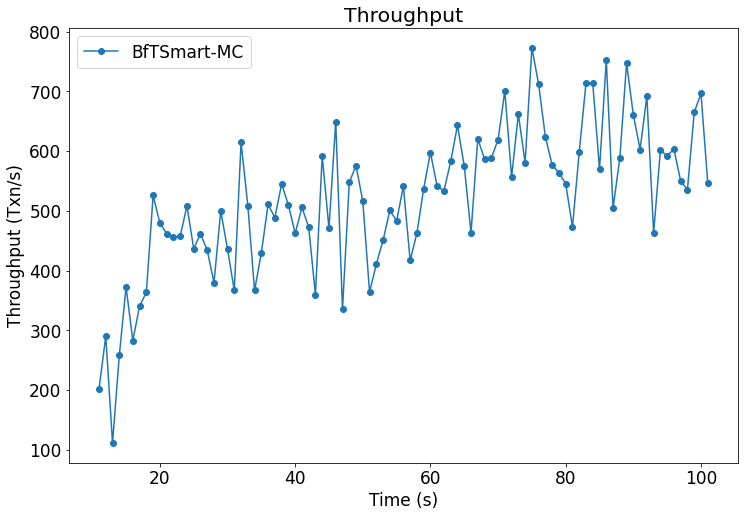

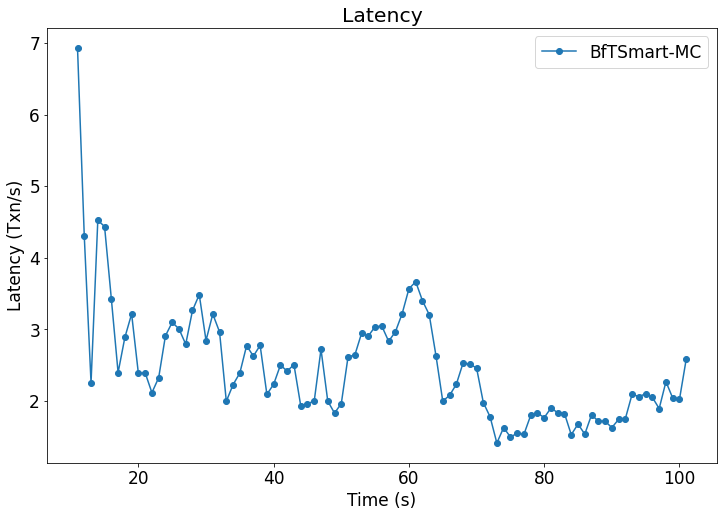

In [22]:
times_thputsDict = {}
times_latsDict = {}

for ip in clientIps[:1]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        times_thputsDict[times[i]] = thputs[i]
        times_latsDict[times[i]] = lats[i]
        

for ip in clientIps[1:]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        
        if times[i] in times_thputsDict.keys():
            times_thputsDict[times[i]] += thputs[i]
            
        if times[i] in times_latsDict.keys():
            times_latsDict[times[i]] += lats[i]
    

PIK = '../Experiments/'+experiment+"/pickle.dat"

data = [times_thputsDict, times_latsDict]

with open(PIK, "wb") as f:
    pickle.dump(data, f)


data2 = []
with open(PIK, "rb") as f:
    data2 =  pickle.load(f)


dict1 = data2[0]
dict2 = data2[1]



times1 = np.array(list(dict1.keys()))
thputs = np.array(list(dict1.values()))

times2 = np.array(list(dict2.keys()))
lats = np.array(list(dict2.values()))

times1

import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
pl.show()




pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], lats[:], '-o', label='BfTSmart-MC')


pl.title(r'Latency')


pl.xlabel('Time (s)')
pl.ylabel('Latency (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
pl.show()

In [33]:
lats, np.average(lats[-35:-5])

(array([6.93469863, 4.3025083 , 2.25416216, 4.52478091, 4.43607541,
        3.42825974, 2.39608898, 2.88673004, 3.21601813, 2.38406778,
        2.39354376, 2.11566563, 2.32491072, 2.91031424, 3.09850583,
        3.00692393, 2.79282197, 3.26419331, 3.48553884, 2.84459478,
        3.21409637, 2.96447504, 1.99551165, 2.22785214, 2.39074885,
        2.7722617 , 2.62669807, 2.77625391, 2.09257187, 2.23342957,
        2.50019732, 2.41749371, 2.50739359, 1.93566109, 1.96134664,
        1.99970234, 2.72214494, 1.99801401, 1.83083705, 1.96363022,
        2.61728685, 2.64094038, 2.94615835, 2.90715645, 3.03914622,
        3.04405252, 2.83390681, 2.96638272, 3.22007059, 3.56709795,
        3.66558282, 3.40108059, 3.20546863, 2.63160406, 1.99826328,
        2.07686468, 2.23149581, 2.52853013, 2.51343138, 2.46148043,
        1.97758882, 1.7786586 , 1.41242124, 1.62725256, 1.49782309,
        1.54663485, 1.53362265, 1.79804957, 1.83280403, 1.76641961,
        1.90191682, 1.83550011, 1.82382399, 1.52

In [34]:
np.sum(thputs),  np.average(thputs[-35:-5])

(47268.81, 619.5089999999999)

echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-13-234-29-126.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-13-232-156-1.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-15-206-194-146.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-13-127-235-249.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-43-204-141-20.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-52-66-253-81.ap-south-1.compute.amazonaws.com:commands.s

echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-65-0-109-191.ap-south-1.compute.amazonaws.com:commands.sh


In [25]:
# np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

In [26]:
# ## Main Job

# # os.system('git add .; git commit -m "test";git push')

# experiment = 'RemoveViewChangeBftSmartMC'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(125)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
#         print(command)
#         os.system(command)

# times_thputsDict = {}
# times_latsDict = {}

# for ip in clientIps[:1]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
#         times_thputsDict[times[i]] = thputs[i]
#         times_latsDict[times[i]] = lats[i]
        

# for ip in clientIps[1:]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
        
#         if times[i] in times_thputsDict.keys():
#             times_thputsDict[times[i]] += thputs[i]
            
#         if times[i] in times_latsDict.keys():
#             times_latsDict[times[i]] += lats[i]
    

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data = [times_thputsDict, times_latsDict]

# with open(PIK, "wb") as f:
#     pickle.dump(data, f)


# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1


# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Remote View Change for BftSmart-MC with timeout = 20 s')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [27]:
# ## Main Job

# # os.system('git add .; git commit -m "test";git push')

# experiment = 'NonLeaderFailure'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(85)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in [3])
# time.sleep(45)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
#         print(command)
#         os.system(command)

# times_thputsDict = {}
# times_latsDict = {}

# for ip in clientIps[:1]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
#         times_thputsDict[times[i]] = thputs[i]
#         times_latsDict[times[i]] = lats[i]
        

# for ip in clientIps[1:]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
        
#         if times[i] in times_thputsDict.keys():
#             times_thputsDict[times[i]] += thputs[i]
            
#         if times[i] in times_latsDict.keys():
#             times_latsDict[times[i]] += lats[i]
    

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data = [times_thputsDict, times_latsDict]

# with open(PIK, "wb") as f:
#     pickle.dump(data, f)


# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [28]:
# experiment = 'NonLeaderFailure'

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')
# pl.axvline(x=85.48, ls='--', color = 'red')

# pl.title(r'Throughput')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [29]:
# ## Main Job

# # os.system('git add .; git commit -m "test";git push')

# experiment = 'LeaderFailure'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(85)

# # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in [0])
# time.sleep(100)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
#         print(command)
#         os.system(command)

# times_thputsDict = {}
# times_latsDict = {}

# for ip in clientIps[:1]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
#         times_thputsDict[times[i]] = thputs[i]
#         times_latsDict[times[i]] = lats[i]
        

# for ip in clientIps[1:]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
        
#         if times[i] in times_thputsDict.keys():
#             times_thputsDict[times[i]] += thputs[i]
            
#         if times[i] in times_latsDict.keys():
#             times_latsDict[times[i]] += lats[i]
    

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data = [times_thputsDict, times_latsDict]

# with open(PIK, "wb") as f:
#     pickle.dump(data, f)


# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [30]:

# def join_node1(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.24.233 11080 11081 config0 >../nohup_j1.out 2>&1 &"'
        
        
#         os.system(command)   
        
        
# def join_node2(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 172.31.19.58 11090 11091 config0 >../nohup_j2.out 2>&1 &"'
        
        
#         os.system(command)
        
        
# def join_node3(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 10 172.31.29.208 11100 11101 config0 >../nohup_j1.out 2>&1 &"'
        
        
#         os.system(command)   
        
        
# def join_node4(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 11 172.31.25.228 11110 11111 1 config1 >../nohup_j2.out 2>&1 &"'
        
        
#         os.system(command)           

# # join_node1(11), join_node2(11)

# # time.sleep(30)
# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(45)
# # print(results)  

# # time.sleep(45)
# # join_node1(11)
# # time.sleep(45)

# # join_node1(11)
# # time.sleep(45)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(85)



# # join_node1(11)
# # time.sleep(85)


# # join_node2(11)
# # time.sleep(85)




# # results = Parallel(n_jobs=len(lines))(delayed(kill_clients)(i) for i in range(len(lines)))
# # time.sleep(25)



# # print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(20)


# # def join_node1_check(i):
# #     ip = lines[i]
# #     if ip!='None':
        
# #         current = (ip.split('.'))
# #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.24.46 11080 11081 config0 >../nohup_j1.out 2>&1 &"'
        
        
# #         print(command)   
        

# # join_node1_check(11)


# # results = Parallel(n_jobs=len(lines))(delayed(kill_clients)(i) for i in range(len(lines)))
# # time.sleep(5)


# # join_node2(11)
# # time.sleep(45)


# # print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(45)




# # join_node2(11)
# # time.sleep(45)




# # join_node3(13)
# # time.sleep(40)
# # join_node4(13)
# # time.sleep(40)

# # time.sleep(50)
# check_node(10)

# # time.sleep(100)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
        
# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j1.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j1.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j2.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j2.out'
#         print(command)
#         os.system(command)        

# ## Byzantine Remote View Change

# times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_c4_11.out')

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput with Byzantine Remote View Change ($nz$=8)')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()


# ## Join End for Checking

# times_all_clients = []
# ops_all_clients = []
# thputs_all_clients = []
# latencies_all_clients = []


# for ip in clientIps:
#     print(lines.index(ip), nreplicas)
    
    
#     with open('../Experiments/'+experiment+'/'+'nohup_c'+str(nreplicas)+'_'+str(lines.index(ip))+'.out') as f:
#         data = f.readlines()
        
    
    

#     times = []
#     ops = []
#     thputs = []
#     latencies = []



#     for line in data:
#         if 'current ops/sec' in line:
#     #         print(line)

#             numbers_string = line.replace('sec:', ':').replace('operations;', ':').replace(\
#                     'current ops/sec; [UPDATE AverageLatency(us)=', ':').replace('] \n', '').replace(' ','')

        
#             if len(numbers_string.split(':')) == 4:

#                 times.append(float(numbers_string.split(':')[0]))
#                 ops.append(float(numbers_string.split(':')[1]))    
#                 thputs.append(float(numbers_string.split(':')[2]))    
#                 latencies.append(float(numbers_string.split(':')[3])/1e6)    



#     times = np.array(times)
#     ops = np.array(ops)
#     thputs = np.array(thputs)
#     latencies = np.array(latencies)
    
#     times_all_clients.append(times)
#     ops_all_clients.append(ops)    
#     thputs_all_clients.append(thputs)    
#     latencies_all_clients.append(latencies)    

# times_all_clients


# times_all_clients_final = []
# ops_all_clients_final = []
# thputs_all_clients_final = []
# latencies_all_clients_final = []

# for iter_, item in enumerate(times_all_clients):
    

#     np.array(list(set(item).intersection(*times_all_clients[:])))
#     # index = in1d(times_all_clients[0],a1)
#     # result = a2[index]

#     both = set(item).intersection(np.array(list(set(item).intersection(*times_all_clients[:]))))

#     indices_A = [list(item).index(x) for x in list(both)]
#     indices_B = [list(set(item).intersection(*times_all_clients[:])).index(x) for x in both]

#     times_all_clients_final.append(item[indices_A])
#     ops_all_clients_final.append(ops_all_clients[iter_][indices_A])
#     thputs_all_clients_final.append(thputs_all_clients[iter_][indices_A])    
#     latencies_all_clients_final.append(latencies_all_clients[iter_][indices_A])    

# times_all = times_all_clients_final[0]
# ops_all = sum(ops_all_clients_final)
# thputs_all = sum(thputs_all_clients_final)
# latencies_all = sum(latencies_all_clients_final)/len(latencies_all_clients_final)


# print('Average Throughput is ',(ops_all[-1] - ops_all[59])/(times_all[-1] - times_all[59]))

# print('Average Latency is', np.average(latencies_all[60:-10]))

# times_all, thputs_all

# # 40 client threads 2 delivery:93+95/81
# # 100 client threads 2 delivery:124+129/81
# # 100 client threads 8 delivery:138+138/81
# # 40 client threads 8 delivery:95+95/81
# # 40 client threads 16 delivery:97+96/81
# # 40 client threads 16 delivery without IO:93+93/81
# # 100 client threads 16 delivery without IO:146+149/81




# (146+149)/81

# check_node(0)

# for i in [0,1, 4, 14, 15]:
# # for i in [1]:
    
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../nohup_c4_'+str(i)+'.out'


#         os.system(command)

# ## Join Experiment

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))



# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))



# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 



# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# # print(results)  

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  



# # time.sleep(30)
# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # print(results)  


# # time.sleep(80)
# # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # for i in [0,1,4,8,12,13,14]:
# # # for i in [1]:
    
# #     ip = lines[i]
# #     if ip!='None':
# #         current = (ip.split('.'))
# #         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../nohup'+str(i)+'.out'


# #         os.system(command)

# check_node(11)

# portStart = 11000 + len(nodeIps)*10

# join_lines = []
# currentPort = portStart

# for i in range(len(no_cluster_yet_nodes)):
#     line = str(len(nodeIps)+i) + ' ' + no_cluster_yet_nodes[i] + ' ' + str(currentPort) + ' '+ str(currentPort+1)
#     currentPort = currentPort + 10
#     join_lines.append(line)
#     print('server',line)

# ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.31.236 11080 11081 config0
# ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 172.31.23.57 11090 11091 config1

# ## KILL ALL JAVA



# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# print(results)  

# ## JOIN COMMAND





# def run_join_client(i):
    
    
    
#     ip = lines[-2]
#     if ip!='None':
#         current = (ip.split('.'))
        
#         join_commands = join_command(i)
        
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmarto; '+join_commands+'"'
        
#         print(command)
#         os.system(command)

# ## JOIN EXPERIMENT

# check_node(3)

# # t1 = time.time()
# # time.sleep(3)
# # t2 = time.time()

# import time
# JoinTimes = []


# t_start = time.time()

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(9)

# time.sleep(40)

# for i in range(4,8):
#     print(i)
#     JoinTimes.append(time.time() - t_start)
#     run_join_client(i)
#     time.sleep(40)
    

# check_node(7)


# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# print(results)  

# ip

# ip = lines[-1]
# if ip!='None':
#     current = (ip.split('.'))
#     command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#           +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out data/MultipleJoins/nohup.out'


#     os.system(command)




# import numpy as np
# import pylab as pl

# times ,thputs, lats = getTimesThputs('data/MultipleJoins/nohup.out')

# JoinTimes

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], thputs[:-10], '-o', label='Existing nodes')


# pl.title(r'Throughput with multiple join requests for Bft-Smart ($nz$=4)')

# pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()



# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], lats[:-10], '-o', label='Existing nodes')


# pl.title(r'Latency with multiple join requests for Bft-Smart ($nz$=4)')

# # pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# # pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# # pl.ylabel(r'Latency ($\mu$s)')
# pl.legend()
# # pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], thputs[:-10]*lats[:-10], '-o', label='Existing nodes')


# pl.title(r'Latency*thput with multiple join requests for Bft-Smart ($nz$=4)')

# # pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# # pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel(r'Latency ($\mu$s)')
# pl.legend()
# # pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()

# ## Random Failure

# os.system('git add .; git commit -m "Fixed Failures and Joins";git push')

# experiment = 'bjoin'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))


# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# # print(results)  

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# def fail_node(i):
#     ip = lines[i]
#     if ip!='None' and ip in nodeIps:
#         current = (ip.split('.'))
                
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo killall java"'
        
#         print(command)
#         os.system(command)

# import numpy as np
# import random

# import time
# # time.sleep(10)

# FailTimes = []


# t_start = time.time()

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(9)

# time.sleep(45)

# for i in random.sample(list(np.arange(1)), 1):
#     print(i)
#     FailTimes.append(time.time() - t_start)
#     fail_node(0)
#     time.sleep(85)
    

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# ip = lines[-1]
# if ip!='None':
#     current = (ip.split('.'))
#     command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#           +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/nohup.out'

#     print(command)
#     os.system(command)

# FailTimes

# times ,thputs, lats = getTimesThputs('../Experiments/nohup.out')

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput with single leader failure ($nz$=8)')

# pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/fig6_leader.png', dpi = 150)
# pl.show()
# pl.clf()


# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
        
# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j1.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j1.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j2.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j2.out'
#         print(command)
#         os.system(command)        

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))